In [1]:
from evaluation_utils import *

**Mean of the throughput**

$$\mu_T = \frac{n}{\mu}$$

where:

- $\mu_T$ is the mean of the throughput
- $n$ is the number of vectors
- $\mu$ is the mean of the execution time per vector


**Standard deviation of the throughput**

$$\sigma_T = \sqrt{\frac{n^2 \sigma^2}{\mu^4}} = \frac{n \sigma}{\mu^2}$$

where:

- $\sigma_T$ is the standard deviation of the throughput
- $n$ is the number of vectors/queries
- $\mu$ is the mean of the execution time per vector/query
- $\sigma^2$ is the variance of the execution time per vector/query

Search space size for the vector search and search_preassigned
- Since we normalized the measurements by dividing by the number of query vectors, here we consider the search space size and the size of the candidates for a single query vector as well.
- Since we're searching through the SIFT1M dataset with $10^6$ vectors, we can compute the number of vectors per list `n_vectors_per_list` given the number of lists `n_lists`:
$$
\text{n\_vectors\_per\_list} = \frac{10^6}{\text{n\_lists}}
$$.
- We find the total number of vectors which need to be searched as the product of `n_vectors_per_list` and `n_probes`, therefore:

$$
\text{n\_vectors\_to\_search} = \text{n\_vectors\_per\_list} * \text{n\_probe} = \frac{10^6}{\text{n\_lists}} * \text{n\_probe}
$$.

- Assuming $128$-dimensional vectors of floats, we can estimate the size of the search space in MB as:
$$
\text{vector\_size\_mb} = \frac{128 * 4}{2^{20}}
$$
$$
\text{search\_space\_size\_mb} = \text{n\_vectors\_to\_search} * \text{vector\_size\_mb}
$$.

- For `preassign_query`, the search space is only proportional to the number of lists since we only need to compare against one centroid per list. Therefore, we can compute the search space size as:
$$
\text{centroids\_total\_size\_mb} = \text{n\_lists} * \text{vector\_size\_mb}
$$.

# `bulk_insert_entries`

## Finding the optimal insertion strategy and buffer size

In [2]:
bie_sift10m_df = results_to_df(merge_results('insertion strategy and buffer size', lambda f: 'SIFT10M' in f and ' O=3 ' in f, 'throughput'), dataset='SIFT10M', mode="bulk_insert_entries")

bie_sift10m_df = bie_sift10m_df.sort_values(['INSERTION_STRATEGY', 'MAX_BUFFER_SIZE'])
bie_sift10m_df

O OMP_SCHEDULE INSERTION_STRATEGY  MAX_BUFFER_SIZE   time_s  s_per_query  \
0   3          nan            dynamic                1  155.330     0.015533   
15  3          nan            dynamic               10  151.212     0.015121   
9   3          nan            dynamic              100  151.291     0.015129   
2   3          nan            dynamic             1000  145.805     0.014581   
14  3      dynamic            dynamic            10000  151.602     0.015160   
4   3      dynamic            dynamic           100000  155.155     0.015515   
1   3      dynamic            dynamic          1000000  145.411     0.014541   
11  3      dynamic            dynamic         10000000  137.721     0.013772   
3   3          nan       preallocated                1  628.369     0.062837   
12  3          nan       preallocated               10  616.200     0.061620   
7   3          nan       preallocated              100  645.927     0.064593   
13  3          nan       preallocated             1000  655.137     0.065514   
5   3          nan       preallocated            10000  703.770     0.070377   
10  3          nan       preallocated           100000  901.455     0.090146   
6   3          nan       preallocated          1000000  817.784     0.081778   
8   3          nan       preallocated         10000000  665.478     0.066548   

    vectors_per_s  queries_per_s  time_s_std  s_per_query_std  \
0    64379.063928      64.379064    6.577510         0.000658   
15   66132.317541      66.132318    0.803585         0.000080   
9    66097.785063      66.097785    2.130420         0.000213   
2    68584.753609      68.584754   10.453100         0.001045   
14   65962.190472      65.962190    3.901320         0.000390   
4    64451.677355      64.451677    4.285810         0.000429   
1    68770.588195      68.770588   13.234100         0.001323   
11   72610.567742      72.610568    2.177280         0.000218   
3    15914.216010      15.914216    1.471480         0.000147   
12   16228.497241      16.228497    3.905310         0.000391   
7    15481.625633      15.481626    1.360840         0.000136   
13   15263.982953      15.263983    4.564640         0.000456   
5    14209.187661      14.209188   68.893300         0.006889   
10   11093.177141      11.093177    3.338130         0.000334   
6    12228.167829      12.228168   22.480200         0.002248   
8    15026.792772      15.026793   94.001900         0.009400   

    vectors_per_s_std  queries_per_s_std   mb_per_s  mb_per_s_std    size_mb  
0         2726.156807           2.726157  31.435090      1.331131  4882.8125  
15         351.446568           0.351447  32.291171      0.171605  4882.8125  
9          930.762856           0.930763  32.274309      0.454474  4882.8125  
2         4917.000706           4.917001  33.488649      2.400879  4882.8125  
14        1697.468456           1.697468  32.208101      0.828842  4882.8125  
4         1780.333494           1.780333  31.470546      0.869303  4882.8125  
1         6258.927050           6.258927  33.579389      3.056117  4882.8125  
11        1147.926147           1.147926  35.454379      0.560511  4882.8125  
3           37.267037           0.037267   7.770613      0.018197  4882.8125  
12         102.851854           0.102852   7.924071      0.050221  4882.8125  
7           32.616713           0.032617   7.559388      0.015926  4882.8125  
13         106.351171           0.106351   7.453117      0.051929  4882.8125  
5         1390.962713           1.390963   6.938080      0.679181  4882.8125  
10          41.078553           0.041079   5.416590      0.020058  4882.8125  
6          336.142133           0.336142   5.970785      0.164132  4882.8125  
8         2122.605212           2.122605   7.337301      1.036428  4882.8125

In [3]:
bie_sift10m_preallocated_df = results_to_df(merge_results('insertion strategy and buffer size', lambda f: 'SIFT10M' in f and ' DIN=0 ' in f and ' O=3 ' in f, 'throughput'), dataset='SIFT10M', mode="bulk_insert_entries")
bie_sift10m_preallocated_df = bie_sift10m_preallocated_df.sort_values(['INSERTION_STRATEGY', 'MAX_BUFFER_SIZE'])
bie_sift10m_preallocated_df = bie_sift10m_preallocated_df.reset_index(drop=True)
bie_sift10m_preallocated_df



O INSERTION_STRATEGY  MAX_BUFFER_SIZE   time_s  s_per_query  vectors_per_s  \
0  3       preallocated                1  628.369     0.062837   15914.216010   
1  3       preallocated               10  616.200     0.061620   16228.497241   
2  3       preallocated              100  645.927     0.064593   15481.625633   
3  3       preallocated             1000  655.137     0.065514   15263.982953   
4  3       preallocated            10000  703.770     0.070377   14209.187661   
5  3       preallocated           100000  901.455     0.090146   11093.177141   
6  3       preallocated          1000000  817.784     0.081778   12228.167829   
7  3       preallocated         10000000  665.478     0.066548   15026.792772   

   queries_per_s  time_s_std  s_per_query_std  vectors_per_s_std  \
0      15.914216     1.47148         0.000147          37.267037   
1      16.228497     3.90531         0.000391         102.851854   
2      15.481626     1.36084         0.000136          32.616713   
3      15.263983     4.56464         0.000456         106.351171   
4      14.209188    68.89330         0.006889        1390.962713   
5      11.093177     3.33813         0.000334          41.078553   
6      12.228168    22.48020         0.002248         336.142133   
7      15.026793    94.00190         0.009400        2122.605212   

   queries_per_s_std  mb_per_s  mb_per_s_std    size_mb  
0           0.037267  7.770613      0.018197  4882.8125  
1           0.102852  7.924071      0.050221  4882.8125  
2           0.032617  7.559388      0.015926  4882.8125  
3           0.106351  7.453117      0.051929  4882.8125  
4           1.390963  6.938080      0.679181  4882.8125  
5           0.041079  5.416590      0.020058  4882.8125  
6           0.336142  5.970785      0.164132  4882.8125  
7           2.122605  7.337301      1.036428  4882.8125

In [4]:
bie_sift10m_dynamic_df = results_to_df(merge_results('insertion strategy and buffer size', lambda f: 'SIFT10M' in f and ' DIN=1 ' in f and ' O=3 ' in f, 'throughput'), dataset='SIFT10M', mode="bulk_insert_entries")
bie_sift10m_dynamic_df = bie_sift10m_dynamic_df.sort_values(['INSERTION_STRATEGY', 'MAX_BUFFER_SIZE'])
bie_sift10m_dynamic_df = bie_sift10m_dynamic_df.reset_index(drop=True)
add_speedup(old_df=bie_sift10m_preallocated_df, new_df=bie_sift10m_dynamic_df, column='mb_per_s')
bie_sift10m_dynamic_df


O OMP_SCHEDULE INSERTION_STRATEGY  MAX_BUFFER_SIZE   time_s  s_per_query  \
0  3          nan            dynamic                1  155.330     0.015533   
1  3          nan            dynamic               10  151.212     0.015121   
2  3          nan            dynamic              100  151.291     0.015129   
3  3          nan            dynamic             1000  145.805     0.014581   
4  3      dynamic            dynamic            10000  151.602     0.015160   
5  3      dynamic            dynamic           100000  155.155     0.015515   
6  3      dynamic            dynamic          1000000  145.411     0.014541   
7  3      dynamic            dynamic         10000000  137.721     0.013772   

   vectors_per_s  queries_per_s  time_s_std  s_per_query_std  \
0   64379.063928      64.379064    6.577510         0.000658   
1   66132.317541      66.132318    0.803585         0.000080   
2   66097.785063      66.097785    2.130420         0.000213   
3   68584.753609      68.584754   10.453100         0.001045   
4   65962.190472      65.962190    3.901320         0.000390   
5   64451.677355      64.451677    4.285810         0.000429   
6   68770.588195      68.770588   13.234100         0.001323   
7   72610.567742      72.610568    2.177280         0.000218   

   vectors_per_s_std  queries_per_s_std   mb_per_s  mb_per_s_std    size_mb  \
0        2726.156807           2.726157  31.435090      1.331131  4882.8125   
1         351.446568           0.351447  32.291171      0.171605  4882.8125   
2         930.762856           0.930763  32.274309      0.454474  4882.8125   
3        4917.000706           4.917001  33.488649      2.400879  4882.8125   
4        1697.468456           1.697468  32.208101      0.828842  4882.8125   
5        1780.333494           1.780333  31.470546      0.869303  4882.8125   
6        6258.927050           6.258927  33.579389      3.056117  4882.8125   
7        1147.926147           1.147926  35.454379      0.560511  4882.8125   

   mb_per_s_speedup  mb_per_s_speedup_std  
0          4.045381              0.171565  
1          4.075073              0.033705  
2          4.269434              0.060790  
3          4.493241              0.323649  
4          4.642221              0.469875  
5          5.810029              0.161925  
6          5.623949              0.534683  
7          4.832074              0.686815

**Throughput**

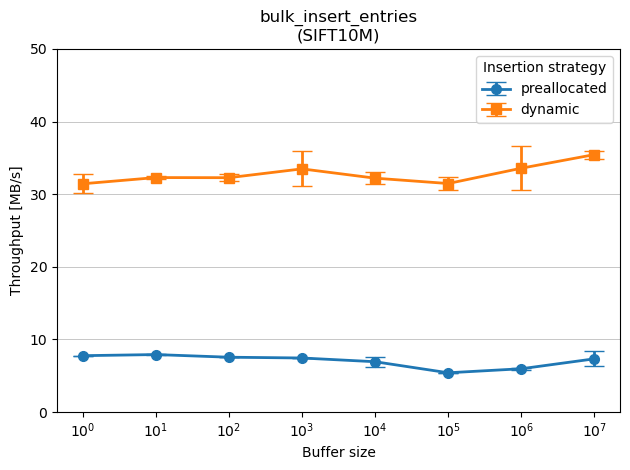

In [5]:
plot(bie_sift10m_df, 'mb_per_s', 'Throughput [MB/s]', 'bulk_insert_entries', subtitle='(SIFT10M)', yerr_col='mb_per_s_std', mode='MAX_BUFFER_SIZE', xaxis_locator=base10_locator, xaxis_formatter=base10_formatter, yaxis_bottom=0, yaxis_top=50, filename='bie-buffer-size')

**Speedup**

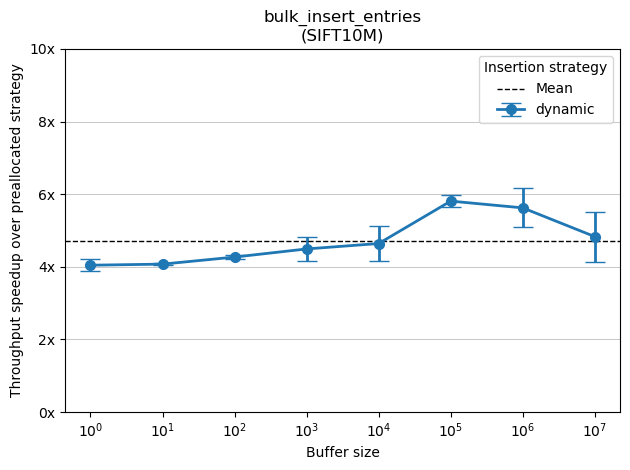

In [6]:
plot(bie_sift10m_dynamic_df, 'mb_per_s_speedup', 'Throughput speedup over preallocated strategy', 'bulk_insert_entries', subtitle='(SIFT10M)', yerr_col='mb_per_s_speedup_std', mode='MAX_BUFFER_SIZE', xaxis_locator=base10_locator, xaxis_formatter=base10_formatter, yformatter=speedup_formatter, show_mean=True, yaxis_bottom=0, yaxis_top=10, filename='bie-buffer-size-speedup')

## Varying number of lists

In [7]:
bie_varying_n_lists = results_to_df(merge_results('bulk insertion varying n_lists', lambda f: True, format='throughput'), dataset='SIFT1M', mode="bulk_insert_entries")
bie_varying_n_lists['n_probes'] = 0
bie_varying_n_lists

O OMP_SCHEDULE INSERTION_STRATEGY  MAX_BUFFER_SIZE  n_lists    time_s  \
0  3      dynamic            dynamic              100      256   8.37962   
1  3      dynamic            dynamic              100      512  11.13850   
2  3      dynamic            dynamic              100     1024  10.81190   
3  3      dynamic            dynamic              100     2048  15.35210   
4  3      dynamic            dynamic              100     4096  16.05110   

   s_per_query  vectors_per_s  queries_per_s  time_s_std  s_per_query_std  \
0     0.000838  119337.153713    1193.371537    1.041680         0.000104   
1     0.001114   89778.695516     897.786955    0.465997         0.000047   
2     0.001081   92490.681564     924.906816    0.606089         0.000061   
3     0.001535   65137.668462     651.376685    0.990748         0.000099   
4     0.001605   62301.026098     623.010261    3.384200         0.000338   

   vectors_per_s_std  queries_per_s_std   mb_per_s  mb_per_s_std    size_mb  \
0       14834.935985         148.349360  58.270095      7.243621  488.28125   
1        3756.035622          37.560356  43.837254      1.834002  488.28125   
2        5184.804216          51.848042  45.161466      2.531643  488.28125   
3        4203.660395          42.036604  31.805502      2.052569  488.28125   
4       13135.494298         131.354943  30.420423      6.413816  488.28125   

   n_probes  
0         0  
1         0  
2         0  
3         0  
4         0

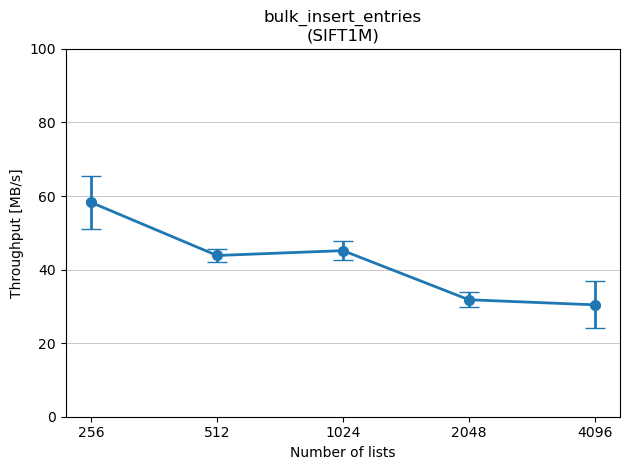

In [8]:
plot(bie_varying_n_lists, 'mb_per_s', 'Throughput [MB/s]', 'bulk_insert_entries', subtitle='(SIFT1M)', yerr_col='mb_per_s_std', mode='n_lists', yaxis_bottom=0, yaxis_top=100, show_legend=False, filename='bie-lists')

## Scaling bulk insertion

In [9]:
bie_merged = pd.DataFrame()
for dataset_size in [1, 10, 100, 1000]:
  dataset = f'SIFT{dataset_size}M'
  bie_not_sorted = results_to_df(merge_results('scaling bulk insertion', lambda f: dataset in f and '~[sorted]' in f, 'throughput'), dataset=dataset, mode="bulk_insert_entries")
  bie_sorted = results_to_df(merge_results('scaling bulk insertion', lambda f: dataset in f and '][sorted]' in f, 'throughput'), dataset=dataset, mode="bulk_insert_entries")
  bie_sorted['INSERTION_STRATEGY'] = 'dynamic (sorted)'
  bie_sorted['dataset_size'] = dataset_size * 10 ** 6
  bie_not_sorted['dataset_size'] = dataset_size * 10 ** 6
  bie_merged = pd.concat([bie_merged, bie_not_sorted, bie_sorted])

bie_merged = bie_merged.sort_values([ 'dataset_size', 'INSERTION_STRATEGY'])
bie_merged = bie_merged.reset_index(drop=True)
bie_merged

O OMP_SCHEDULE INSERTION_STRATEGY  MAX_BUFFER_SIZE      time_s  \
0   3.0      dynamic            dynamic            100.0     12.4936   
1   3.0      dynamic   dynamic (sorted)            100.0      4.2928   
2   3.0      dynamic       preallocated            100.0     59.8523   
3   3.0      dynamic            dynamic            100.0    147.2610   
4   3.0      dynamic   dynamic (sorted)            100.0     27.5203   
5   3.0      dynamic       preallocated            100.0    764.7670   
6   3.0      dynamic            dynamic            100.0   2101.1300   
7   3.0      dynamic   dynamic (sorted)            100.0    422.9890   
8   3.0      dynamic       preallocated            100.0   8610.5600   
9   3.0      dynamic            dynamic            100.0  30177.3000   
10  3.0      dynamic       preallocated            100.0  84533.9000   

    s_per_query  vectors_per_s  queries_per_s   time_s_std  s_per_query_std  \
0      0.001249   80040.980982     800.409810     1.106410         0.000111   
1      0.000429  232948.192322    2329.481923     0.023651         0.000002   
2      0.005985   16707.795690     167.077957     0.425478         0.000043   
3      0.014726   67906.641949      67.906642     6.910140         0.000691   
4      0.002752  363368.131888     363.368132     0.076378         0.000008   
5      0.076477   13075.878013      13.075878     7.089790         0.000709   
6      0.210113   47593.437817       4.759344   277.775000         0.027777   
7      0.042299  236412.767235      23.641277    80.244000         0.008024   
8      0.861056   11613.646499       1.161365   825.395000         0.082540   
9      3.017730   33137.490763       0.331375  2365.500000         0.236550   
10     8.453390   11829.573698       0.118296  4382.030000         0.438203   

    vectors_per_s_std  queries_per_s_std    mb_per_s  mb_per_s_std  \
0         7088.280541          70.882805   39.082510      3.461074   
1         1283.418211          12.834182  113.744235      0.626669   
2          118.772370           1.187724    8.158103      0.057994   
3         3186.481165           3.186481   33.157540      1.555899   
4         1008.468931           1.008469  177.425846      0.492416   
5          121.220227           0.121220    6.384706      0.059190   
6         6291.979644           0.629198   23.238983      3.072256   
7        44849.171241           4.484917  115.435922     21.899009   
8         1113.266240           0.111327    5.670726      0.543587   
9         2597.539687           0.025975   16.180415      1.268330   
10         613.216081           0.006132    5.776159      0.299422   

         size_mb  dataset_size  
0      488.28125       1000000  
1      488.28125       1000000  
2      488.28125       1000000  
3     4882.81250      10000000  
4     4882.81250      10000000  
5     4882.81250      10000000  
6    48828.12500     100000000  
7    48828.12500     100000000  
8    48828.12500     100000000  
9   488281.25000    1000000000  
10  488281.25000    1000000000

In [10]:
# split bie_merged by INSERTION_STRATEGY
bie_merged_dynamic = bie_merged[bie_merged['INSERTION_STRATEGY'] == 'dynamic']
bie_merged_dynamic.reset_index(drop=True, inplace=True)
bie_merged_dynamic

O OMP_SCHEDULE INSERTION_STRATEGY  MAX_BUFFER_SIZE      time_s  \
0  3.0      dynamic            dynamic            100.0     12.4936   
1  3.0      dynamic            dynamic            100.0    147.2610   
2  3.0      dynamic            dynamic            100.0   2101.1300   
3  3.0      dynamic            dynamic            100.0  30177.3000   

   s_per_query  vectors_per_s  queries_per_s  time_s_std  s_per_query_std  \
0     0.001249   80040.980982     800.409810     1.10641         0.000111   
1     0.014726   67906.641949      67.906642     6.91014         0.000691   
2     0.210113   47593.437817       4.759344   277.77500         0.027777   
3     3.017730   33137.490763       0.331375  2365.50000         0.236550   

   vectors_per_s_std  queries_per_s_std   mb_per_s  mb_per_s_std  \
0        7088.280541          70.882805  39.082510      3.461074   
1        3186.481165           3.186481  33.157540      1.555899   
2        6291.979644           0.629198  23.238983      3.072256   
3        2597.539687           0.025975  16.180415      1.268330   

        size_mb  dataset_size  
0     488.28125       1000000  
1    4882.81250      10000000  
2   48828.12500     100000000  
3  488281.25000    1000000000

In [11]:

bie_merged_dynamic_sorted = bie_merged[bie_merged['INSERTION_STRATEGY'] == 'dynamic (sorted)']
bie_merged_dynamic_sorted.reset_index(drop=True, inplace=True)
bie_merged_dynamic_sorted


O OMP_SCHEDULE INSERTION_STRATEGY  MAX_BUFFER_SIZE    time_s  \
0  3.0      dynamic   dynamic (sorted)            100.0    4.2928   
1  3.0      dynamic   dynamic (sorted)            100.0   27.5203   
2  3.0      dynamic   dynamic (sorted)            100.0  422.9890   

   s_per_query  vectors_per_s  queries_per_s  time_s_std  s_per_query_std  \
0     0.000429  232948.192322    2329.481923    0.023651         0.000002   
1     0.002752  363368.131888     363.368132    0.076378         0.000008   
2     0.042299  236412.767235      23.641277   80.244000         0.008024   

   vectors_per_s_std  queries_per_s_std    mb_per_s  mb_per_s_std  \
0        1283.418211          12.834182  113.744235      0.626669   
1        1008.468931           1.008469  177.425846      0.492416   
2       44849.171241           4.484917  115.435922     21.899009   

       size_mb  dataset_size  
0    488.28125       1000000  
1   4882.81250      10000000  
2  48828.12500     100000000

In [12]:

bie_merged_preallocated = bie_merged[bie_merged['INSERTION_STRATEGY'] == 'preallocated']
bie_merged_preallocated.reset_index(drop=True, inplace=True)
bie_merged_preallocated

O OMP_SCHEDULE INSERTION_STRATEGY  MAX_BUFFER_SIZE      time_s  \
0  3.0      dynamic       preallocated            100.0     59.8523   
1  3.0      dynamic       preallocated            100.0    764.7670   
2  3.0      dynamic       preallocated            100.0   8610.5600   
3  3.0      dynamic       preallocated            100.0  84533.9000   

   s_per_query  vectors_per_s  queries_per_s   time_s_std  s_per_query_std  \
0     0.005985   16707.795690     167.077957     0.425478         0.000043   
1     0.076477   13075.878013      13.075878     7.089790         0.000709   
2     0.861056   11613.646499       1.161365   825.395000         0.082540   
3     8.453390   11829.573698       0.118296  4382.030000         0.438203   

   vectors_per_s_std  queries_per_s_std  mb_per_s  mb_per_s_std       size_mb  \
0         118.772370           1.187724  8.158103      0.057994     488.28125   
1         121.220227           0.121220  6.384706      0.059190    4882.81250   
2        1113.266240           0.111327  5.670726      0.543587   48828.12500   
3         613.216081           0.006132  5.776159      0.299422  488281.25000   

   dataset_size  
0       1000000  
1      10000000  
2     100000000  
3    1000000000

In [13]:
# compute speedups of dynamic over preinitialized
add_speedup(old_df=bie_merged_preallocated, new_df=bie_merged_dynamic, column='mb_per_s')

# compute speedups of dynamic (sorted) over preallocated
add_speedup(old_df=bie_merged_preallocated[bie_merged_preallocated['dataset_size'] <= 10 ** 8], new_df=bie_merged_dynamic_sorted, column='mb_per_s')


bie_merged_speedups = pd.concat([bie_merged_dynamic, bie_merged_dynamic_sorted])
bie_merged_speedups


/pub/scratch/tfercho/ann-dkvs/evaluation/evaluation_utils.py:366: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[column + suffix] = speedup
/pub/scratch/tfercho/ann-dkvs/evaluation/evaluation_utils.py:367: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[column + suffix + '_std'] = speedup_std
/pub/scratch/tfercho/ann-dkvs/evaluation/evaluation_utils.py:366: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

O OMP_SCHEDULE INSERTION_STRATEGY  MAX_BUFFER_SIZE      time_s  \
0  3.0      dynamic            dynamic            100.0     12.4936   
1  3.0      dynamic            dynamic            100.0    147.2610   
2  3.0      dynamic            dynamic            100.0   2101.1300   
3  3.0      dynamic            dynamic            100.0  30177.3000   
0  3.0      dynamic   dynamic (sorted)            100.0      4.2928   
1  3.0      dynamic   dynamic (sorted)            100.0     27.5203   
2  3.0      dynamic   dynamic (sorted)            100.0    422.9890   

   s_per_query  vectors_per_s  queries_per_s   time_s_std  s_per_query_std  \
0     0.001249   80040.980982     800.409810     1.106410         0.000111   
1     0.014726   67906.641949      67.906642     6.910140         0.000691   
2     0.210113   47593.437817       4.759344   277.775000         0.027777   
3     3.017730   33137.490763       0.331375  2365.500000         0.236550   
0     0.000429  232948.192322    2329.481923     0.023651         0.000002   
1     0.002752  363368.131888     363.368132     0.076378         0.000008   
2     0.042299  236412.767235      23.641277    80.244000         0.008024   

   vectors_per_s_std  queries_per_s_std    mb_per_s  mb_per_s_std  \
0        7088.280541          70.882805   39.082510      3.461074   
1        3186.481165           3.186481   33.157540      1.555899   
2        6291.979644           0.629198   23.238983      3.072256   
3        2597.539687           0.025975   16.180415      1.268330   
0        1283.418211          12.834182  113.744235      0.626669   
1        1008.468931           1.008469  177.425846      0.492416   
2       44849.171241           4.484917  115.435922     21.899009   

        size_mb  dataset_size  mb_per_s_speedup  mb_per_s_speedup_std  
0     488.28125       1000000          4.790637              0.425615  
1    4882.81250      10000000          5.193276              0.248402  
2   48828.12500     100000000          4.098062              0.669207  
3  488281.25000    1000000000          2.801241              0.263251  
0     488.28125       1000000         13.942485              0.125396  
1    4882.81250      10000000         27.789196              0.268917  
2   48828.12500     100000000         20.356463              4.326772

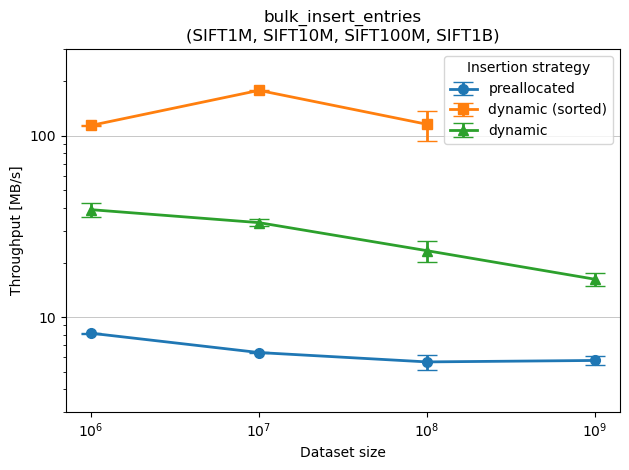

In [14]:
plot(bie_merged, 'mb_per_s', 'Throughput [MB/s]', 'bulk_insert_entries', subtitle='(SIFT1M, SIFT10M, SIFT100M, SIFT1B)', yerr_col='mb_per_s_std', mode='dataset_size', xaxis_locator=base10_locator, xaxis_formatter=base10_formatter, yaxis_bottom=3, yaxis_top=300, yaxis_log=True, filename='bie-dataset-size')

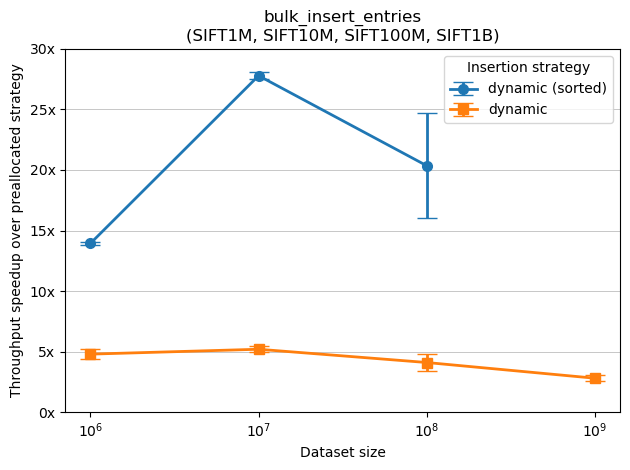

In [15]:
plot(bie_merged_speedups, 'mb_per_s_speedup', 'Throughput speedup over preallocated strategy', 'bulk_insert_entries', subtitle='(SIFT1M, SIFT10M, SIFT100M, SIFT1B)', yerr_col='mb_per_s_speedup_std', mode='dataset_size', xaxis_locator=base10_locator, xaxis_formatter=base10_formatter, yformatter=speedup_formatter, show_mean=False, yaxis_bottom=0, yaxis_top=30, filename='bie-dataset-size-speedup')

# No SIMD, No OpenMP

## `preassign_query()`

Parsing measurements from xml output of testing framework

In [16]:
centroids_df = results_to_df(merge_results('Vanilla', lambda f: 'preassign_query' in f and 'throughput' in f, 'throughput'), mode="preassign_query")
centroids_df

O OMP_SCHEDULE INSERTION_STRATEGY  MAX_BUFFER_SIZE  n_lists  n_probes  \
0   3      dynamic            dynamic              100      256         1   
1   3      dynamic            dynamic              100      256         2   
2   3      dynamic            dynamic              100      256         4   
3   3      dynamic            dynamic              100      256         8   
4   3      dynamic            dynamic              100      256        16   
5   3      dynamic            dynamic              100      256        32   
6   3      dynamic            dynamic              100      256        64   
7   3      dynamic            dynamic              100      256       128   
8   3      dynamic            dynamic              100      512         1   
9   3      dynamic            dynamic              100      512         2   
10  3      dynamic            dynamic              100      512         4   
11  3      dynamic            dynamic              100      512         8   
12  3      dynamic            dynamic              100      512        16   
13  3      dynamic            dynamic              100      512        32   
14  3      dynamic            dynamic              100      512        64   
15  3      dynamic            dynamic              100      512       128   
16  3      dynamic            dynamic              100     1024         1   
17  3      dynamic            dynamic              100     1024         2   
18  3      dynamic            dynamic              100     1024         4   
19  3      dynamic            dynamic              100     1024         8   
20  3      dynamic            dynamic              100     1024        16   
21  3      dynamic            dynamic              100     1024        32   
22  3      dynamic            dynamic              100     1024        64   
23  3      dynamic            dynamic              100     1024       128   
24  3      dynamic            dynamic              100     2048         1   
25  3      dynamic            dynamic              100     2048         2   
26  3      dynamic            dynamic              100     2048         4   
27  3      dynamic            dynamic              100     2048         8   
28  3      dynamic            dynamic              100     2048        16   
29  3      dynamic            dynamic              100     2048        32   
30  3      dynamic            dynamic              100     2048        64   
31  3      dynamic            dynamic              100     2048       128   
32  3      dynamic            dynamic              100     4096         1   
33  3      dynamic            dynamic              100     4096         2   
34  3      dynamic            dynamic              100     4096         4   
35  3      dynamic            dynamic              100     4096         8   
36  3      dynamic            dynamic              100     4096        16   
37  3      dynamic            dynamic              100     4096        32   
38  3      dynamic            dynamic              100     4096        64   
39  3      dynamic            dynamic              100     4096       128   

    n_results    time_s  s_per_query  vectors_per_s  queries_per_s  \
0          10  0.317565     0.000032   3.148962e+06   31489.616299   
1          10  0.321192     0.000032   3.113403e+06   31134.025754   
2          10  0.328409     0.000033   3.044984e+06   30449.835419   
3          10  0.340147     0.000034   2.939905e+06   29399.053938   
4          10  0.363280     0.000036   2.752698e+06   27526.976437   
5          10  0.404803     0.000040   2.470337e+06   24703.374234   
6          10  0.464201     0.000046   2.154239e+06   21542.392196   
7          10  0.527388     0.000053   1.896137e+06   18961.371893   
8          10  0.628286     0.000063   1.591632e+06   15916.318365   
9          10  0.633178     0.000063   1.579335e+06   15793.347210   
10         10  0.643048     0.000064   1.555094e+06   15550.938655   
11    

In [17]:
centroids_latency_df = results_to_df(merge_results('Vanilla', lambda f: 'latency' in f and 'preassign_query' in f, 'latency'), mode="preassign_query")
centroids_latency_df

O OMP_SCHEDULE INSERTION_STRATEGY  MAX_BUFFER_SIZE  n_lists  n_probes  \
0   3      dynamic            dynamic              100      256         1   
1   3      dynamic            dynamic              100      256         2   
2   3      dynamic            dynamic              100      256         4   
3   3      dynamic            dynamic              100      256         8   
4   3      dynamic            dynamic              100      256        16   
5   3      dynamic            dynamic              100      256        32   
6   3      dynamic            dynamic              100      256        64   
7   3      dynamic            dynamic              100      256       128   
8   3      dynamic            dynamic              100      512         1   
9   3      dynamic            dynamic              100      512         2   
10  3      dynamic            dynamic              100      512         4   
11  3      dynamic            dynamic              100      512         8   
12  3      dynamic            dynamic              100      512        16   
13  3      dynamic            dynamic              100      512        32   
14  3      dynamic            dynamic              100      512        64   
15  3      dynamic            dynamic              100      512       128   
16  3      dynamic            dynamic              100     1024         1   
17  3      dynamic            dynamic              100     1024         2   
18  3      dynamic            dynamic              100     1024         4   
19  3      dynamic            dynamic              100     1024         8   
20  3      dynamic            dynamic              100     1024        16   
21  3      dynamic            dynamic              100     1024        32   
22  3      dynamic            dynamic              100     1024        64   
23  3      dynamic            dynamic              100     1024       128   
24  3      dynamic            dynamic              100     2048         1   
25  3      dynamic            dynamic              100     2048         2   
26  3      dynamic            dynamic              100     2048         4   
27  3      dynamic            dynamic              100     2048         8   
28  3      dynamic            dynamic              100     2048        16   
29  3      dynamic            dynamic              100     2048        32   
30  3      dynamic            dynamic              100     2048        64   
31  3      dynamic            dynamic              100     2048       128   
32  3      dynamic            dynamic              100     4096         1   
33  3      dynamic            dynamic              100     4096         2   
34  3      dynamic            dynamic              100     4096         4   
35  3      dynamic            dynamic              100     4096         8   
36  3      dynamic            dynamic              100     4096        16   
37  3      dynamic            dynamic              100     4096        32   
38  3      dynamic            dynamic              100     4096        64   
39  3      dynamic            dynamic              100     4096       128   

    n_results  latency_50th  latency_50th_std  latency_95th  latency_95th_std  \
0          10      0.000032      3.300000e-08      0.000032      3.400000e-08   
1          10      0.000032      0.000000e+00      0.000032      4.000000e-09   
2          10      0.000033      1.600000e-08      0.000033      1.200000e-08   
3          10      0.000034      2.100000e-08      0.000035      8.500000e-08   
4          10      0.000036      1.100000e-08      0.000037      1.500000e-08   
5          10      0.000039      1.800000e-08      0.000040      1.800000e-08   
6          10      0.000044      1.000000e-08      0.000046      7.000000e-09   
7          10      0.000050      5.000000e-09      0.000051      8.000000e-09   
8          10      0.000063      1.000000e-09      0.000063      3.000000e-09   
9          10      0.000064      3.0

**Search Space Size**

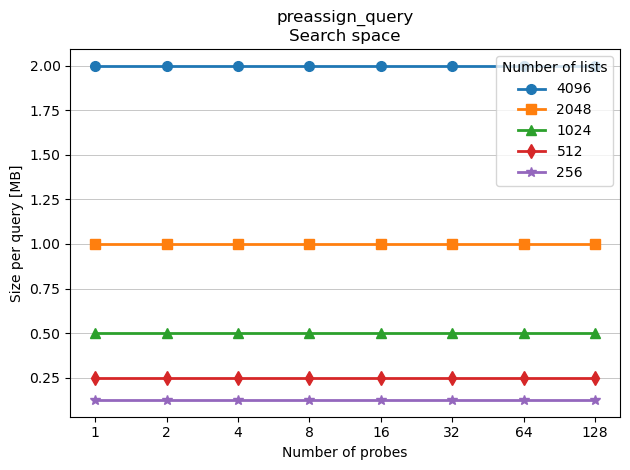

In [18]:
plot(centroids_df, y_col='size_per_query_mb', ylabel='Size per query [MB]', title='preassign_query', subtitle='Search space', mode='n_probes', yaxis_log=False, filename='search-space-preassign')

**Throughput**

- Search space = number of centroids to compare against = `n_lists`
- Candidates = number of closest centroids to find = `n_probes`
- For a fixed `n_lists` and increasing `n_probes`, we expect the throughput to decrease since we need to compare against the current list of `n_probes` candidates (using a heap) while searching through the constant search space which is fixed with the number of lists.

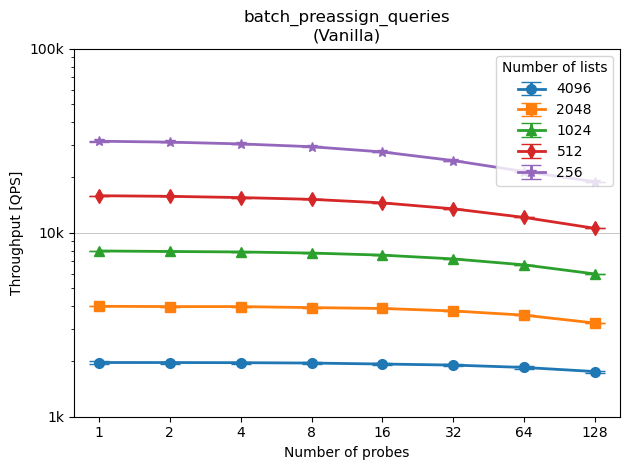

In [19]:
plot(df=centroids_df, y_col='queries_per_s', yerr_col='queries_per_s_std', ylabel='Throughput [QPS]', title='batch_preassign_queries', subtitle='(Vanilla)', yaxis_log=True, yaxis_bottom=1e3, yaxis_top=100e3, yformatter=to_k_formatter)

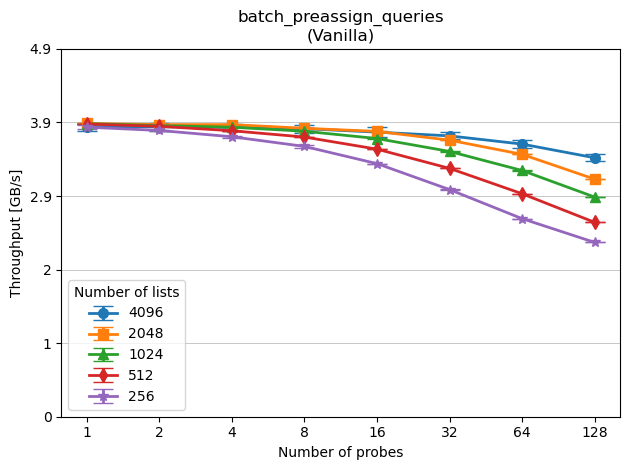

In [20]:
plot(df=centroids_df, y_col='mb_per_s', yerr_col='mb_per_s_std', ylabel='Throughput [GB/s]', title='batch_preassign_queries', subtitle='(Vanilla)', yformatter=mb_to_gb_formatter, yaxis_log=False, yaxis_bottom=0, yaxis_top=5e3, filename='vanilla-preassign-throughput')

**Latency**

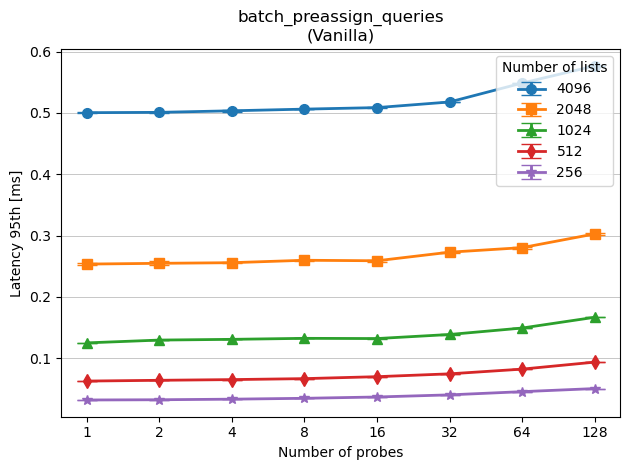

In [21]:
plot(df=centroids_latency_df, y_col='latency_95th', yerr_col='latency_95th_std', title='batch_preassign_queries', subtitle='(Vanilla)', ylabel='Latency 95th [ms]', mode='n_probes', yformatter=s_to_ms_formatter, yaxis_log=False, filename='vanilla-preassign-latency-95')

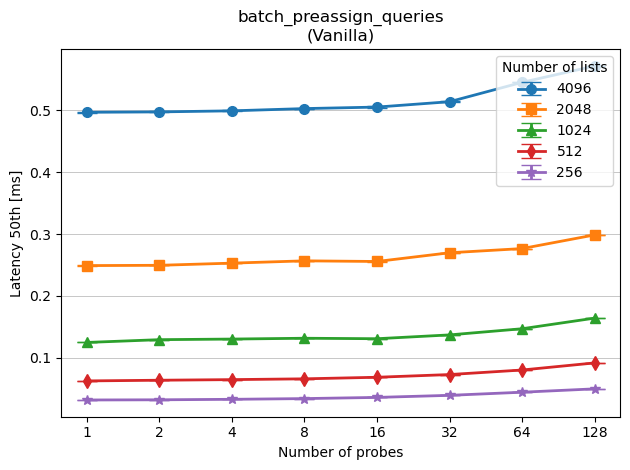

In [22]:
plot(df=centroids_latency_df, y_col='latency_50th', yerr_col='latency_50th_std', title='batch_preassign_queries', subtitle='(Vanilla)', ylabel='Latency 50th [ms]', mode='n_probes', yformatter=s_to_ms_formatter, yaxis_log=False, filename='vanilla-preassign-latency-50')

## `search_preassigned`

In [23]:
search_df = results_to_df(merge_results('Vanilla', lambda f: 'search_preassigned' in f and 'throughput' in f, 'throughput'), mode='search_preassigned')
search_df

O OMP_SCHEDULE INSERTION_STRATEGY  MAX_BUFFER_SIZE  n_lists  n_probes  \
0   3      dynamic            dynamic              100      256         1   
1   3      dynamic            dynamic              100      256         2   
2   3      dynamic            dynamic              100      256         4   
3   3      dynamic            dynamic              100      256         8   
4   3      dynamic            dynamic              100      256        16   
5   3      dynamic            dynamic              100      256        32   
6   3      dynamic            dynamic              100      256        64   
7   3      dynamic            dynamic              100      256       128   
8   3      dynamic            dynamic              100      512         1   
9   3      dynamic            dynamic              100      512         2   
10  3      dynamic            dynamic              100      512         4   
11  3      dynamic            dynamic              100      512         8   
12  3      dynamic            dynamic              100      512        16   
13  3      dynamic            dynamic              100      512        32   
14  3      dynamic            dynamic              100      512        64   
15  3      dynamic            dynamic              100      512       128   
16  3      dynamic            dynamic              100     1024         1   
17  3      dynamic            dynamic              100     1024         2   
18  3      dynamic            dynamic              100     1024         4   
19  3      dynamic            dynamic              100     1024         8   
20  3      dynamic            dynamic              100     1024        16   
21  3      dynamic            dynamic              100     1024        32   
22  3      dynamic            dynamic              100     1024        64   
23  3      dynamic            dynamic              100     1024       128   
24  3      dynamic            dynamic              100     2048         1   
25  3      dynamic            dynamic              100     2048         2   
26  3      dynamic            dynamic              100     2048         4   
27  3      dynamic            dynamic              100     2048         8   
28  3      dynamic            dynamic              100     2048        16   
29  3      dynamic            dynamic              100     2048        32   
30  3      dynamic            dynamic              100     2048        64   
31  3      dynamic            dynamic              100     2048       128   
32  3      dynamic            dynamic              100     4096         1   
33  3      dynamic            dynamic              100     4096         2   
34  3      dynamic            dynamic              100     4096         4   
35  3      dynamic            dynamic              100     4096         8   
36  3      dynamic            dynamic              100     4096        16   
37  3      dynamic            dynamic              100     4096        32   
38  3      dynamic            dynamic              100     4096        64   
39  3      dynamic            dynamic              100     4096       128   

    n_results      time_s  s_per_query  vectors_per_s  queries_per_s  \
0          10    5.317810     0.000532   1.880473e+05    1880.473353   
1          10   10.388500     0.001039   9.626029e+04     962.602878   
2          10   20.394200     0.002039   4.903355e+04     490.335488   
3          10   39.994000     0.003999   2.500375e+04     250.037506   
4          10   78.493700     0.007849   1.273988e+04     127.398759   
5          10  154.102000     0.015410   6.489208e+03      64.892084   
6          10  303.686000     0.030369   3.292875e+03      32.928749   
7          10  603.629000     0.060363   1.656647e+03      16.566467   
8          10    2.731770     0.000273   3.660630e+05    3660.630287   
9          10    5.370910     0.000537   1.861882e+05    1861.881878   
10         10   10.483200     0.001048   9.539072e+04 

In [24]:
search_latency_df = results_to_df(merge_results('Vanilla', lambda f: 'latency' in f and 'search_preassigned' in f, 'latency'), mode='search_preassigned')
search_latency_df

O OMP_SCHEDULE INSERTION_STRATEGY  MAX_BUFFER_SIZE  n_lists  n_probes  \
0   3      dynamic            dynamic              100      256         1   
1   3      dynamic            dynamic              100      256         2   
2   3      dynamic            dynamic              100      256         4   
3   3      dynamic            dynamic              100      256         8   
4   3      dynamic            dynamic              100      256        16   
5   3      dynamic            dynamic              100      256        32   
6   3      dynamic            dynamic              100      256        64   
7   3      dynamic            dynamic              100      256       128   
8   3      dynamic            dynamic              100      512         1   
9   3      dynamic            dynamic              100      512         2   
10  3      dynamic            dynamic              100      512         4   
11  3      dynamic            dynamic              100      512         8   
12  3      dynamic            dynamic              100      512        16   
13  3      dynamic            dynamic              100      512        32   
14  3      dynamic            dynamic              100      512        64   
15  3      dynamic            dynamic              100      512       128   
16  3      dynamic            dynamic              100     1024         1   
17  3      dynamic            dynamic              100     1024         2   
18  3      dynamic            dynamic              100     1024         4   
19  3      dynamic            dynamic              100     1024         8   
20  3      dynamic            dynamic              100     1024        16   
21  3      dynamic            dynamic              100     1024        32   
22  3      dynamic            dynamic              100     1024        64   
23  3      dynamic            dynamic              100     1024       128   
24  3      dynamic            dynamic              100     2048         1   
25  3      dynamic            dynamic              100     2048         2   
26  3      dynamic            dynamic              100     2048         4   
27  3      dynamic            dynamic              100     2048         8   
28  3      dynamic            dynamic              100     2048        16   
29  3      dynamic            dynamic              100     2048        32   
30  3      dynamic            dynamic              100     2048        64   
31  3      dynamic            dynamic              100     2048       128   
32  3      dynamic            dynamic              100     4096         1   
33  3      dynamic            dynamic              100     4096         2   
34  3      dynamic            dynamic              100     4096         4   
35  3      dynamic            dynamic              100     4096         8   
36  3      dynamic            dynamic              100     4096        16   
37  3      dynamic            dynamic              100     4096        32   
38  3      dynamic            dynamic              100     4096        64   
39  3      dynamic            dynamic              100     4096       128   

    n_results  latency_50th  latency_50th_std  latency_95th  latency_95th_std  \
0          10      0.000497      3.530000e-07      0.000792      4.910000e-07   
1          10      0.000971      5.260000e-07      0.001488      1.223500e-05   
2          10      0.001920      2.128000e-06      0.002794      1.527600e-05   
3          10      0.003825      1.015500e-05      0.005162      2.468900e-05   
4          10      0.007570      2.169000e-06      0.009570      3.540000e-06   
5          10      0.015014      1.941400e-05      0.017634      2.749200e-05   
6          10      0.029853      1.188000e-05      0.033205      1.561800e-05   
7          10      0.059720      1.097400e-05      0.063785      2.877800e-05   
8          10      0.000245      2.290000e-07      0.000449      3.720000e-07   
9          10      0.000485      4.4

**Search Space Size**

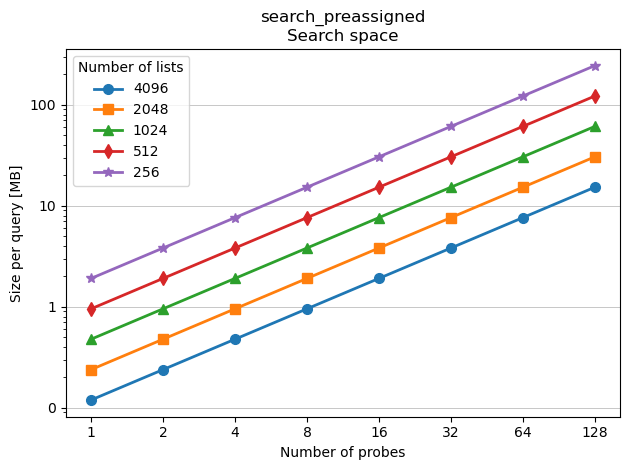

In [25]:
plot(search_df, y_col='size_per_query_mb', ylabel='Size per query [MB]', title='search_preassigned', subtitle='Search space', yaxis_log=True, mode='n_probes', filename='search-space-search')

**Througput**

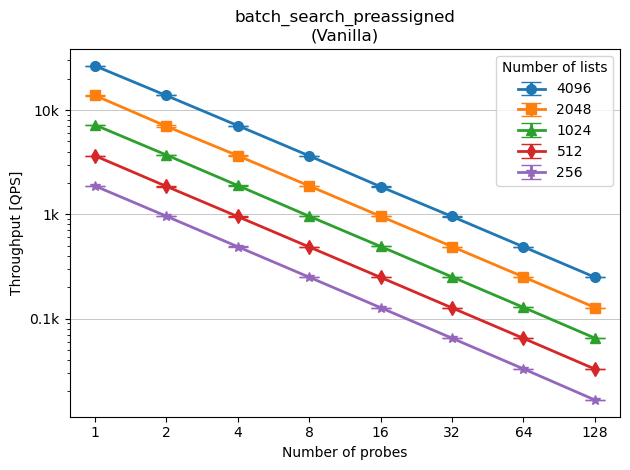

In [26]:
plot(df=search_df, y_col='queries_per_s', yerr_col='queries_per_s_std', title='batch_search_preassigned', subtitle='(Vanilla)', ylabel='Throughput [QPS]', yaxis_log=True, yformatter=to_k_formatter, filename='vanilla-search-throughput-qps')

- Search space ~ 1 / number of lists * number of vectors per list = 1 / `n_lists` * `n_vectors_per_list`
- For a fixed `n_lists` and increasing `n_probes`, the throughput increases since we increase the search space size which reduces the relative overhead of the search.
- For a fixed `n_probes` and increasing `n_lists`, the throughput decreases since the length of the individual lists is smaller which reduces the search space size and could lead to more overhead.


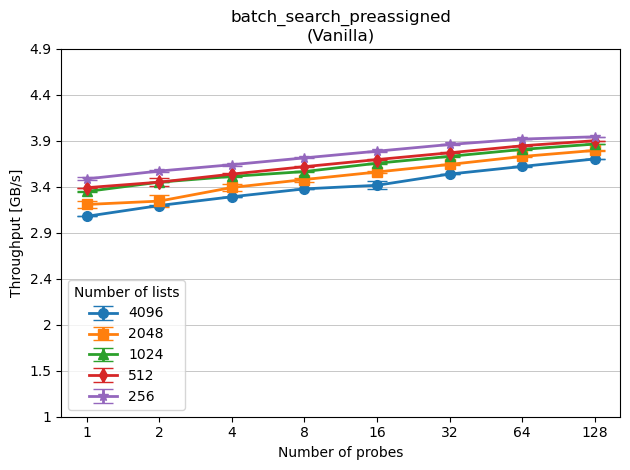

In [27]:
plot(df=search_df, y_col='mb_per_s', yerr_col='mb_per_s_std', title='batch_search_preassigned', subtitle='(Vanilla)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter, yaxis_bottom=1e3, yaxis_top=5e3, filename='vanilla-search-throughput')

**Latency**


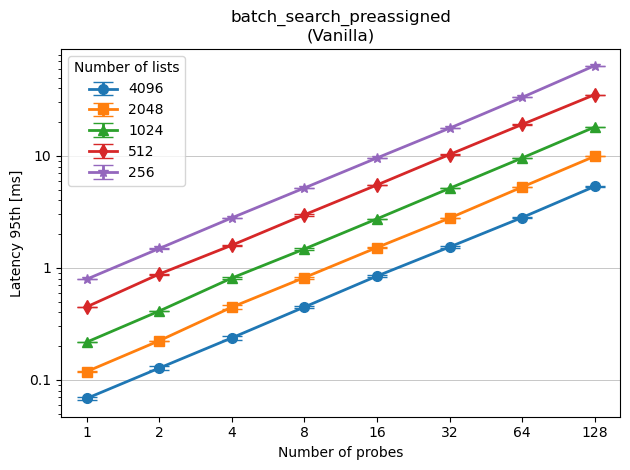

In [28]:
plot(df=search_latency_df, y_col='latency_95th', yerr_col='latency_95th_std', title='batch_search_preassigned', subtitle='(Vanilla)', ylabel='Latency 95th [ms]', mode='n_probes', yformatter=s_to_ms_formatter, yaxis_log=True, filename='vanilla-search-latency-95')

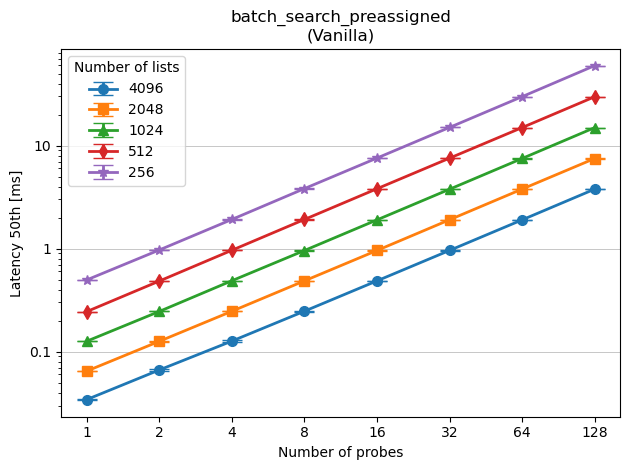

In [29]:
plot(df=search_latency_df, y_col='latency_50th', yerr_col='latency_50th_std', title='batch_search_preassigned', subtitle='(Vanilla)', ylabel='Latency 50th [ms]', mode='n_probes', yformatter=s_to_ms_formatter, yaxis_log=True, filename='vanilla-search-latency-50')

# SIMD, no OpenMP

## `preassign_query()`

In [30]:
centroids_simd_df = results_to_df(merge_results('SIMD', lambda f: 'preassign_query' in f and 'throughput' in f, 'throughput'), mode="preassign_query")
add_speedup(old_df=centroids_df, new_df=centroids_simd_df, column='mb_per_s')
centroids_simd_df

O OMP_SCHEDULE INSERTION_STRATEGY  MAX_BUFFER_SIZE  n_lists  n_probes  \
0   3      dynamic            dynamic              100      256         1   
1   3      dynamic            dynamic              100      256         2   
2   3      dynamic            dynamic              100      256         4   
3   3      dynamic            dynamic              100      256         8   
4   3      dynamic            dynamic              100      256        16   
5   3      dynamic            dynamic              100      256        32   
6   3      dynamic            dynamic              100      256        64   
7   3      dynamic            dynamic              100      256       128   
8   3      dynamic            dynamic              100      512         1   
9   3      dynamic            dynamic              100      512         2   
10  3      dynamic            dynamic              100      512         4   
11  3      dynamic            dynamic              100      512         8   
12  3      dynamic            dynamic              100      512        16   
13  3      dynamic            dynamic              100      512        32   
14  3      dynamic            dynamic              100      512        64   
15  3      dynamic            dynamic              100      512       128   
16  3      dynamic            dynamic              100     1024         1   
17  3      dynamic            dynamic              100     1024         2   
18  3      dynamic            dynamic              100     1024         4   
19  3      dynamic            dynamic              100     1024         8   
20  3      dynamic            dynamic              100     1024        16   
21  3      dynamic            dynamic              100     1024        32   
22  3      dynamic            dynamic              100     1024        64   
23  3      dynamic            dynamic              100     1024       128   
24  3      dynamic            dynamic              100     2048         1   
25  3      dynamic            dynamic              100     2048         2   
26  3      dynamic            dynamic              100     2048         4   
27  3      dynamic            dynamic              100     2048         8   
28  3      dynamic            dynamic              100     2048        16   
29  3      dynamic            dynamic              100     2048        32   
30  3      dynamic            dynamic              100     2048        64   
31  3      dynamic            dynamic              100     2048       128   
32  3      dynamic            dynamic              100     4096         1   
33  3      dynamic            dynamic              100     4096         2   
34  3      dynamic            dynamic              100     4096         4   
35  3      dynamic            dynamic              100     4096         8   
36  3      dynamic            dynamic              100     4096        16   
37  3      dynamic            dynamic              100     4096        32   
38  3      dynamic            dynamic              100     4096        64   
39  3      dynamic            dynamic              100     4096       128   

    n_results    time_s  s_per_query  vectors_per_s  ...  time_s_std  \
0          10  0.078731     0.000008   1.270143e+07  ...    0.001178   
1          10  0.081325     0.000008   1.229631e+07  ...    0.000854   
2          10  0.084763     0.000008   1.179754e+07  ...    0.000008   
3          10  0.093836     0.000009   1.065690e+07  ...    0.000025   
4          10  0.111113     0.000011   8.999847e+06  ...    0.000082   
5          10  0.143925     0.000014   6.948063e+06  ...    0.000118   
6          10  0.180677     0.000018   5.534739e+06  ...    0.000096   
7          10  0.238300     0.000024   4.196391e+06  ...    0.000411   
8          10  0.138688     0.000014   7.210429e+06  ...    0.000281   
9          10  0.143752     0.000014   6.956425e+06  ...    0.000273   
10         10  0.149084     0.000015   6.707628e+06  .

In [31]:
centroids_simd_latency_df = results_to_df(merge_results('SIMD', lambda f: 'latency' in f and 'preassign_query' in f, 'latency'), mode="preassign_query")
add_speedup(old_df=centroids_latency_df, new_df=centroids_simd_latency_df, column='latency_95th', invert=True)
centroids_simd_latency_df

O OMP_SCHEDULE INSERTION_STRATEGY  MAX_BUFFER_SIZE  n_lists  n_probes  \
0   3      dynamic            dynamic              100      256         1   
1   3      dynamic            dynamic              100      256         2   
2   3      dynamic            dynamic              100      256         4   
3   3      dynamic            dynamic              100      256         8   
4   3      dynamic            dynamic              100      256        16   
5   3      dynamic            dynamic              100      256        32   
6   3      dynamic            dynamic              100      256        64   
7   3      dynamic            dynamic              100      256       128   
8   3      dynamic            dynamic              100      512         1   
9   3      dynamic            dynamic              100      512         2   
10  3      dynamic            dynamic              100      512         4   
11  3      dynamic            dynamic              100      512         8   
12  3      dynamic            dynamic              100      512        16   
13  3      dynamic            dynamic              100      512        32   
14  3      dynamic            dynamic              100      512        64   
15  3      dynamic            dynamic              100      512       128   
16  3      dynamic            dynamic              100     1024         1   
17  3      dynamic            dynamic              100     1024         2   
18  3      dynamic            dynamic              100     1024         4   
19  3      dynamic            dynamic              100     1024         8   
20  3      dynamic            dynamic              100     1024        16   
21  3      dynamic            dynamic              100     1024        32   
22  3      dynamic            dynamic              100     1024        64   
23  3      dynamic            dynamic              100     1024       128   
24  3      dynamic            dynamic              100     2048         1   
25  3      dynamic            dynamic              100     2048         2   
26  3      dynamic            dynamic              100     2048         4   
27  3      dynamic            dynamic              100     2048         8   
28  3      dynamic            dynamic              100     2048        16   
29  3      dynamic            dynamic              100     2048        32   
30  3      dynamic            dynamic              100     2048        64   
31  3      dynamic            dynamic              100     2048       128   
32  3      dynamic            dynamic              100     4096         1   
33  3      dynamic            dynamic              100     4096         2   
34  3      dynamic            dynamic              100     4096         4   
35  3      dynamic            dynamic              100     4096         8   
36  3      dynamic            dynamic              100     4096        16   
37  3      dynamic            dynamic              100     4096        32   
38  3      dynamic            dynamic              100     4096        64   
39  3      dynamic            dynamic              100     4096       128   

    n_results  latency_50th  latency_50th_std  latency_95th  latency_95th_std  \
0          10      0.000007      7.000000e-09      0.000007      9.000000e-09   
1          10      0.000008      2.000000e-09      0.000008      1.000000e-09   
2          10      0.000008      3.000000e-09      0.000008      2.000000e-09   
3          10      0.000009      3.000000e-09      0.000009      5.000000e-09   
4          10      0.000010      6.000000e-09      0.000010      9.000000e-09   
5          10      0.000012      3.000000e-09      0.000012      6.000000e-09   
6          10      0.000015      4.000000e-09      0.000016      2.000000e-09   
7          10      0.000021      5.000000e-09      0.000021      6.000000e-09   
8          10      0.000015      6.000000e-09      0.000015      7.000000e-09   
9          10      0.000015      3.0

**Throughput**

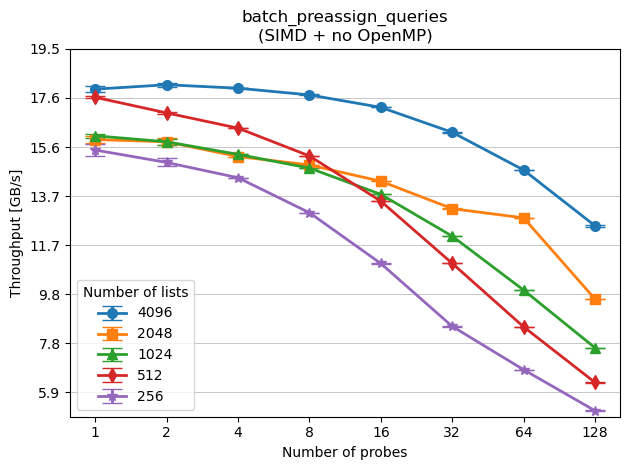

In [32]:
plot(df=centroids_simd_df, y_col='mb_per_s', yerr_col='mb_per_s_std', title='batch_preassign_queries', subtitle='(SIMD + no OpenMP)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter, yaxis_bottom=5e3, yaxis_top=20e3, filename='simd-preassign-throughput')

**Latency**

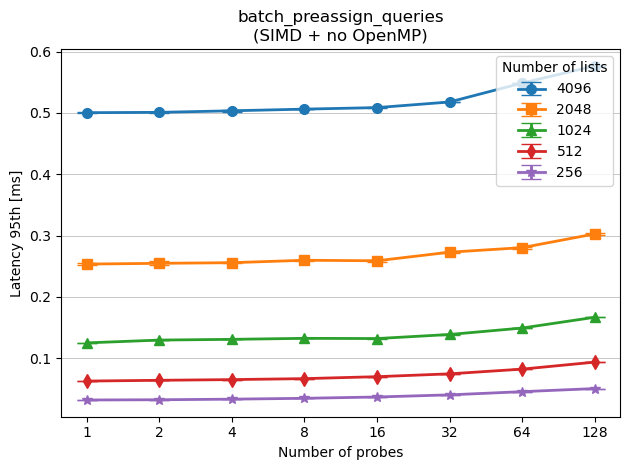

In [33]:
plot(df=centroids_latency_df, y_col='latency_95th', yerr_col='latency_95th_std', title='batch_preassign_queries', subtitle='(SIMD + no OpenMP)', ylabel='Latency 95th [ms]', mode='n_probes', yformatter=s_to_ms_formatter, yaxis_log=False, filename='simd-preassign-latency-95')

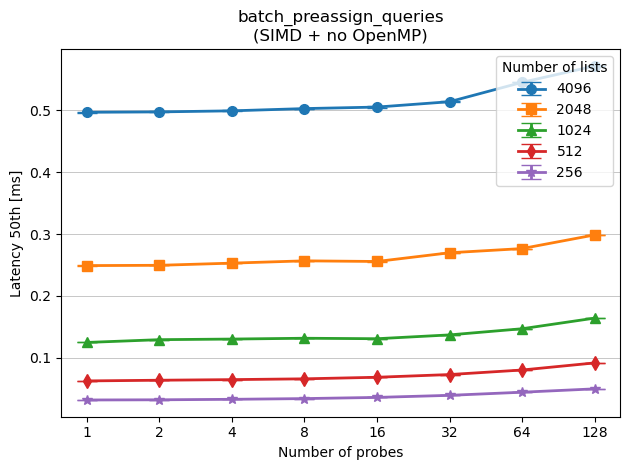

In [34]:
plot(df=centroids_latency_df, y_col='latency_50th', yerr_col='latency_50th_std', title='batch_preassign_queries', subtitle='(SIMD + no OpenMP)', ylabel='Latency 50th [ms]', mode='n_probes', yformatter=s_to_ms_formatter, yaxis_log=False, filename='simd-preassign-latency-50')

**Speedup**

Average SIMD speedup for preassign_query(): 3.8x


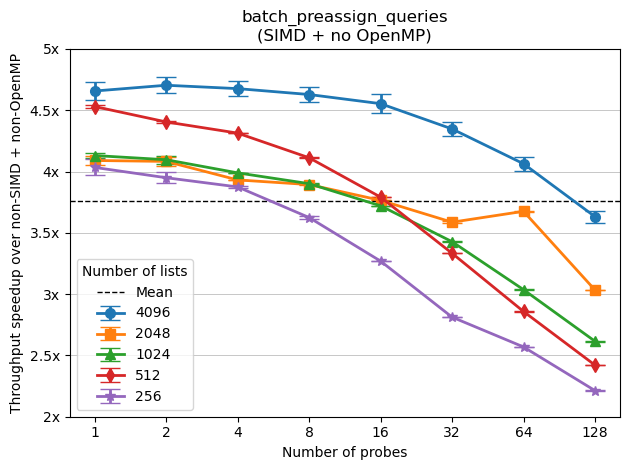

In [35]:
speedup = centroids_simd_df['mb_per_s_speedup'].mean()
print(f'Average SIMD speedup for preassign_query(): {speedup:.1f}x')
plot(df=centroids_simd_df, y_col='mb_per_s_speedup', yerr_col='mb_per_s_speedup_std', title='batch_preassign_queries', subtitle='(SIMD + no OpenMP)', ylabel='Throughput speedup over non-SIMD + non-OpenMP', yaxis_bottom=2, yaxis_top=5, show_mean=True, filename='simd-preassign-throughput-speedup', yformatter=speedup_formatter)

Average SIMD Latency 99th speedup for preassign_query(): 4.0x


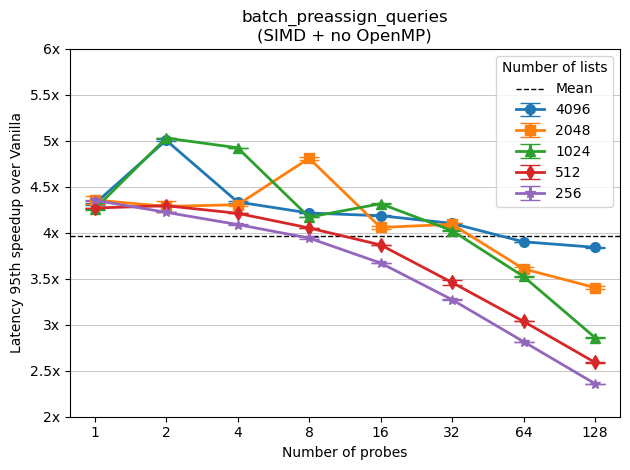

In [36]:
speedup = centroids_simd_latency_df['latency_95th_speedup'].mean()
print(f'Average SIMD Latency 99th speedup for preassign_query(): {speedup:.1f}x')
plot(df=centroids_simd_latency_df, y_col='latency_95th_speedup', yerr_col='latency_95th_speedup_std', title='batch_preassign_queries', subtitle='(SIMD + no OpenMP)', ylabel='Latency 95th speedup over Vanilla', yaxis_bottom=2, yaxis_top=6, show_mean=True, yformatter=speedup_formatter, filename='simd-preassign-latency-95-speedup')

## `search_preassigned()`

In [37]:
search_simd_df = results_to_df(merge_results('SIMD', lambda f: 'search_preassigned' in f and 'throughput' in f, 'throughput'), mode='search_preassigned')
add_speedup(old_df=search_df, new_df=search_simd_df, column='mb_per_s')
search_simd_df

O OMP_SCHEDULE INSERTION_STRATEGY  MAX_BUFFER_SIZE  n_lists  n_probes  \
0   3      dynamic            dynamic              100      256         1   
1   3      dynamic            dynamic              100      256         2   
2   3      dynamic            dynamic              100      256         4   
3   3      dynamic            dynamic              100      256         8   
4   3      dynamic            dynamic              100      256        16   
5   3      dynamic            dynamic              100      256        32   
6   3      dynamic            dynamic              100      256        64   
7   3      dynamic            dynamic              100      256       128   
8   3      dynamic            dynamic              100      512         1   
9   3      dynamic            dynamic              100      512         2   
10  3      dynamic            dynamic              100      512         4   
11  3      dynamic            dynamic              100      512         8   
12  3      dynamic            dynamic              100      512        16   
13  3      dynamic            dynamic              100      512        32   
14  3      dynamic            dynamic              100      512        64   
15  3      dynamic            dynamic              100      512       128   
16  3      dynamic            dynamic              100     1024         1   
17  3      dynamic            dynamic              100     1024         2   
18  3      dynamic            dynamic              100     1024         4   
19  3      dynamic            dynamic              100     1024         8   
20  3      dynamic            dynamic              100     1024        16   
21  3      dynamic            dynamic              100     1024        32   
22  3      dynamic            dynamic              100     1024        64   
23  3      dynamic            dynamic              100     1024       128   
24  3      dynamic            dynamic              100     2048         1   
25  3      dynamic            dynamic              100     2048         2   
26  3      dynamic            dynamic              100     2048         4   
27  3      dynamic            dynamic              100     2048         8   
28  3      dynamic            dynamic              100     2048        16   
29  3      dynamic            dynamic              100     2048        32   
30  3      dynamic            dynamic              100     2048        64   
31  3      dynamic            dynamic              100     2048       128   
32  3      dynamic            dynamic              100     4096         1   
33  3      dynamic            dynamic              100     4096         2   
34  3      dynamic            dynamic              100     4096         4   
35  3      dynamic            dynamic              100     4096         8   
36  3      dynamic            dynamic              100     4096        16   
37  3      dynamic            dynamic              100     4096        32   
38  3      dynamic            dynamic              100     4096        64   
39  3      dynamic            dynamic              100     4096       128   

    n_results      time_s  s_per_query  vectors_per_s  ...  time_s_std  \
0          10    1.885750     0.000189   5.302930e+05  ...    0.009437   
1          10    3.699340     0.000370   2.703185e+05  ...    0.025378   
2          10    7.268810     0.000727   1.375741e+05  ...    0.024396   
3          10   14.299500     0.001430   6.993252e+04  ...    0.046884   
4          10   28.030800     0.002803   3.567504e+04  ...    0.046106   
5          10   55.216100     0.005522   1.811066e+04  ...    0.002189   
6          10  108.551000     0.010855   9.212260e+03  ...    0.041041   
7          10  216.140000     0.021614   4.626631e+03  ...    0.083324   
8          10    0.972739     0.000097   1.028025e+06  ...    0.002281   
9          10    1.893990     0.000189   5.279859e+05  ...    0.012244   
10         10    3.691660     0.

In [38]:
search_simd_latency_df = results_to_df(merge_results('SIMD', lambda f: 'latency' in f and 'search_preassigned' in f, 'latency'), mode='search_preassigned')
add_speedup(old_df=search_latency_df, new_df=search_simd_latency_df, column='latency_95th', invert=True)
search_simd_latency_df

O OMP_SCHEDULE INSERTION_STRATEGY  MAX_BUFFER_SIZE  n_lists  n_probes  \
0   3      dynamic            dynamic              100      256         1   
1   3      dynamic            dynamic              100      256         2   
2   3      dynamic            dynamic              100      256         4   
3   3      dynamic            dynamic              100      256         8   
4   3      dynamic            dynamic              100      256        16   
5   3      dynamic            dynamic              100      256        32   
6   3      dynamic            dynamic              100      256        64   
7   3      dynamic            dynamic              100      256       128   
8   3      dynamic            dynamic              100      512         1   
9   3      dynamic            dynamic              100      512         2   
10  3      dynamic            dynamic              100      512         4   
11  3      dynamic            dynamic              100      512         8   
12  3      dynamic            dynamic              100      512        16   
13  3      dynamic            dynamic              100      512        32   
14  3      dynamic            dynamic              100      512        64   
15  3      dynamic            dynamic              100      512       128   
16  3      dynamic            dynamic              100     1024         1   
17  3      dynamic            dynamic              100     1024         2   
18  3      dynamic            dynamic              100     1024         4   
19  3      dynamic            dynamic              100     1024         8   
20  3      dynamic            dynamic              100     1024        16   
21  3      dynamic            dynamic              100     1024        32   
22  3      dynamic            dynamic              100     1024        64   
23  3      dynamic            dynamic              100     1024       128   
24  3      dynamic            dynamic              100     2048         1   
25  3      dynamic            dynamic              100     2048         2   
26  3      dynamic            dynamic              100     2048         4   
27  3      dynamic            dynamic              100     2048         8   
28  3      dynamic            dynamic              100     2048        16   
29  3      dynamic            dynamic              100     2048        32   
30  3      dynamic            dynamic              100     2048        64   
31  3      dynamic            dynamic              100     2048       128   
32  3      dynamic            dynamic              100     4096         1   
33  3      dynamic            dynamic              100     4096         2   
34  3      dynamic            dynamic              100     4096         4   
35  3      dynamic            dynamic              100     4096         8   
36  3      dynamic            dynamic              100     4096        16   
37  3      dynamic            dynamic              100     4096        32   
38  3      dynamic            dynamic              100     4096        64   
39  3      dynamic            dynamic              100     4096       128   

    n_results  latency_50th  latency_50th_std  latency_95th  latency_95th_std  \
0          10      0.000176      3.620000e-07      0.000280      1.007000e-06   
1          10      0.000344      9.640000e-07      0.000528      1.246500e-05   
2          10      0.000680      8.130000e-07      0.000989      5.792000e-06   
3          10      0.001353      7.910000e-07      0.001833      8.627000e-06   
4          10      0.002678      1.465000e-06      0.003390      9.053000e-06   
5          10      0.005322      1.599000e-06      0.006246      7.044000e-06   
6          10      0.012044      5.047000e-06      0.014057      8.760000e-06   
7          10      0.021111      5.035000e-06      0.022530      4.875000e-06   
8          10      0.000087      2.200000e-08      0.000158      1.560000e-07   
9          10      0.000169      7.4

**Throughput**

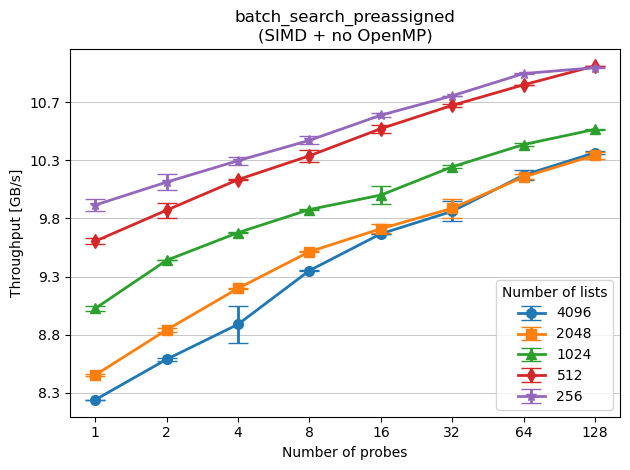

In [39]:
plot(df=search_simd_df, y_col='mb_per_s', yerr_col='mb_per_s_std', title='batch_search_preassigned', subtitle='(SIMD + no OpenMP)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter, filename='simd-search-throughput')

**Latency**

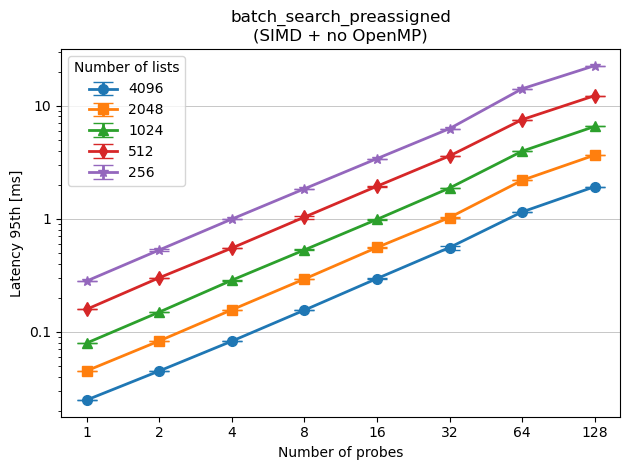

In [40]:
plot(df=search_simd_latency_df, y_col='latency_95th', yerr_col='latency_95th_std', title='batch_search_preassigned', subtitle='(SIMD + no OpenMP)', ylabel='Latency 95th [ms]', mode='n_probes', yformatter=s_to_ms_formatter, yaxis_log=True, filename='simd-search-latency-95')

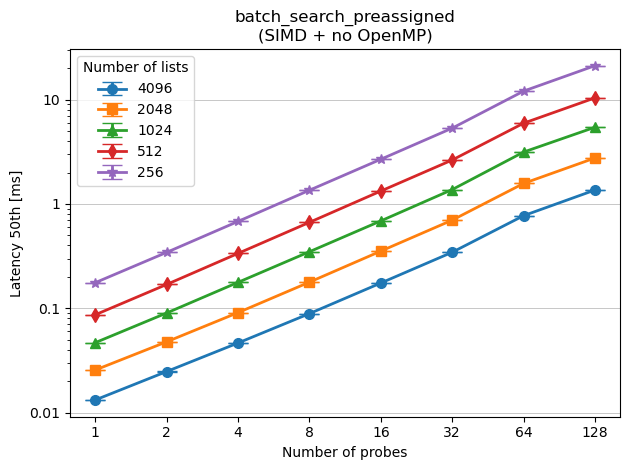

In [41]:
plot(df=search_simd_latency_df, y_col='latency_50th', yerr_col='latency_50th_std', title='batch_search_preassigned', subtitle='(SIMD + no OpenMP)', ylabel='Latency 50th [ms]', mode='n_probes', yformatter=s_to_ms_formatter, yaxis_log=True, filename='simd-search-latency-50')

**Speedup**

Average SIMD speedup for search_preassigned(): 2.8x


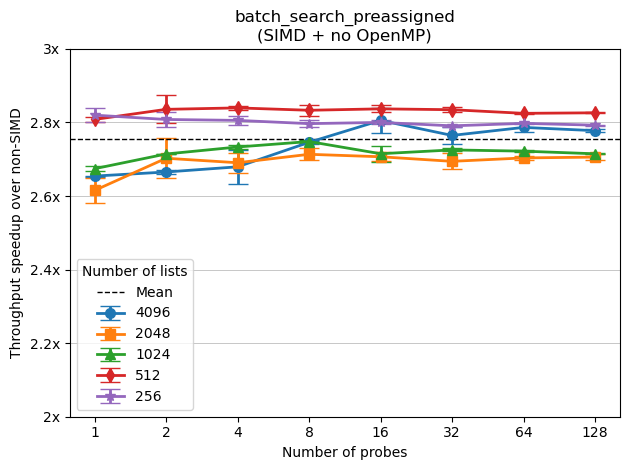

In [42]:
speedup = search_simd_df['mb_per_s_speedup'].mean()
print(f'Average SIMD speedup for search_preassigned(): {speedup:.1f}x')
plot(df=search_simd_df, y_col='mb_per_s_speedup', yerr_col='mb_per_s_speedup_std', title='batch_search_preassigned', subtitle='(SIMD + no OpenMP)', ylabel='Throughput speedup over non-SIMD', yformatter=speedup_formatter, show_mean=True, yaxis_bottom=2, yaxis_top=3, filename='simd-search-throughput-speedup')

Average SIMD Latency 95th speedup for preassign_query(): 2.8x


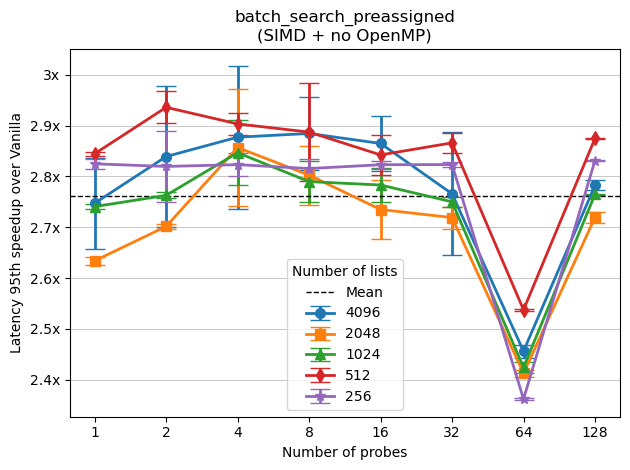

In [43]:
speedup = search_simd_latency_df['latency_95th_speedup'].mean()
print(f'Average SIMD Latency 95th speedup for preassign_query(): {speedup:.1f}x')
plot(df=search_simd_latency_df, y_col='latency_95th_speedup', yerr_col='latency_95th_speedup_std', title='batch_search_preassigned', subtitle='(SIMD + no OpenMP)', ylabel='Latency 95th speedup over Vanilla', show_mean=True, filename='simd-search-latency-95-speedup', yformatter=speedup_formatter)

# SIMD, OpenMP (over queries)

- The following benchmarks were executed on a `Intel Xeon E5-2640 @ 2.4 GHz` with 16 cores, each with 2 threads.
- OpenMP was configured to use up to `16` threads by configuring `OMP_NUM_THREADS`, an environment variable which sets the maximum thread count.

## `search_preassigned()`: Finding the optimal number of threads

In [44]:
threads_throughput_df = results_to_df(merge_results('schedule and max number of threads', lambda f: 'throughput' in f, 'throughput'), mode='search_preassigned')

threads_throughput_df = threads_throughput_df.sort_values(by=['OMP_SCHEDULE', 'max_n_threads'])
threads_throughput_df


O OMP_SCHEDULE  max_n_threads INSERTION_STRATEGY  MAX_BUFFER_SIZE  \
11  3      dynamic              1            dynamic            10000   
12  3      dynamic              2            dynamic            10000   
13  3      dynamic              4            dynamic            10000   
14  3      dynamic              8            dynamic            10000   
15  3      dynamic             16            dynamic            10000   
16  3      dynamic             32            dynamic            10000   
17  3      dynamic             64            dynamic            10000   
18  3      dynamic            128            dynamic            10000   
19  3      dynamic            256            dynamic            10000   
20  3      dynamic            512            dynamic            10000   
21  3      dynamic           1024            dynamic            10000   
0   3       guided              1            dynamic            10000   
1   3       guided              2            dynamic            10000   
2   3       guided              4            dynamic            10000   
3   3       guided              8            dynamic            10000   
4   3       guided             16            dynamic            10000   
5   3       guided             32            dynamic            10000   
6   3       guided             64            dynamic            10000   
7   3       guided            128            dynamic            10000   
8   3       guided            256            dynamic            10000   
9   3       guided            512            dynamic            10000   
10  3       guided           1024            dynamic            10000   
22  3       static              1            dynamic            10000   
23  3       static              2            dynamic            10000   
24  3       static              4            dynamic            10000   
25  3       static              8            dynamic            10000   
26  3       static             16            dynamic            10000   
27  3       static             32            dynamic            10000   
28  3       static             64            dynamic            10000   
29  3       static            128            dynamic            10000   
30  3       static            256            dynamic            10000   
31  3       static            512            dynamic            10000   
32  3       static           1024            dynamic            10000   

    n_lists  n_probes  n_results   time_s  s_per_query  vectors_per_s  \
11     1024        16         10  8.30522     0.000831  120406.202364   
12     1024        16         10  4.16674     0.000417  239995.776074   
13     1024        16         10  2.22738     0.000223  448957.968555   
14     1024        16         10  1.63379     0.000163  612073.767130   
15     1024        16         10  1.54225     0.000154  648403.306857   
16     1024        16         10  1.49617     0.000150  668373.246356   
17     1024        16         10  1.54368     0.000154  647802.653400   
18     1024        16         10  1.52626     0.000153  655196.362350   
19     1024        16         10  1.56172     0.000156  640319.647568   
20     1024        16         10  1.55983     0.000156  641095.503997   
21     1024        16         10  1.56509     0.000157  638940.891578   
0      1024        16         10  8.26548     0.000827  120985.109153   
1      1024        16         10  4.20760     0.000421  237665.177298   
2      1024        16         10  2.21595     0.000222  451273.720075   
3      1024        16         10  1.74677     0.000175  572485.215569   
4      1024        16         10  2.07757     0.000208  481331.555615   
5      1024        16         10  2.27134     0.000227  440268.740039   
6      1024        16         10  2.04781     0.000205  488326.553733   
7      1024        16         10  1.71015     0.000171  584744.028302   
8      1024        16         10  1.68913     0.000169  59202

**Throughput**

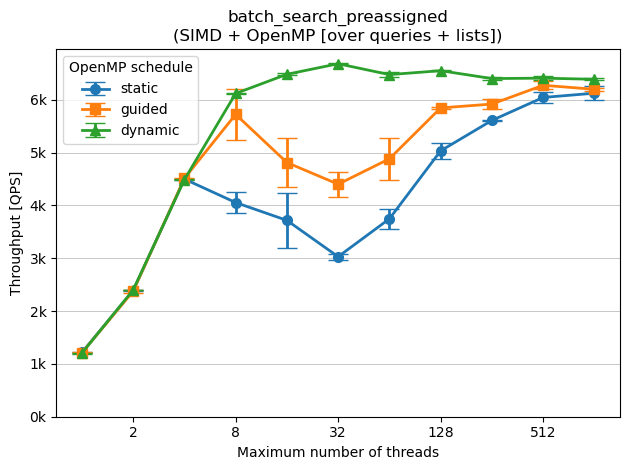

In [45]:
plot(df=threads_throughput_df, y_col='queries_per_s', yerr_col='queries_per_s_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists])', ylabel='Throughput [QPS]', mode='max_n_threads', yformatter=to_k_formatter, yaxis_log=False, yaxis_bottom=0)

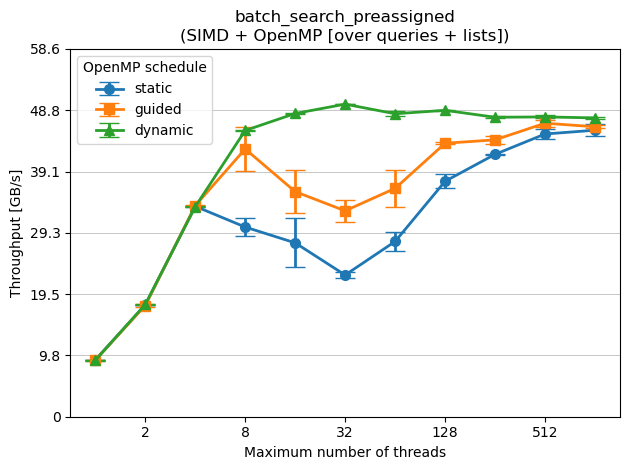

In [46]:
plot(df=threads_throughput_df, y_col='mb_per_s',yerr_col='mb_per_s_std',title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists])', ylabel='Throughput [GB/s]', mode='max_n_threads', yformatter=mb_to_gb_formatter, yaxis_bottom=0, yaxis_top=60e3, filename='omp-threads-throughput')

**Latency**

In [47]:
threads_latency_df = results_to_df(merge_results('schedule and max number of threads', lambda f: 'latency' in f, 'latency'), mode='search_preassigned')
threads_latency_df = threads_latency_df.sort_values(by=['OMP_SCHEDULE', 'max_n_threads'])
threads_latency_df

O OMP_SCHEDULE  max_n_threads INSERTION_STRATEGY  MAX_BUFFER_SIZE  \
11  3      dynamic              1            dynamic            10000   
12  3      dynamic              2            dynamic            10000   
13  3      dynamic              4            dynamic            10000   
14  3      dynamic              8            dynamic            10000   
15  3      dynamic             16            dynamic            10000   
16  3      dynamic             32            dynamic            10000   
17  3      dynamic             64            dynamic            10000   
18  3      dynamic            128            dynamic            10000   
19  3      dynamic            256            dynamic            10000   
20  3      dynamic            512            dynamic            10000   
21  3      dynamic           1024            dynamic            10000   
0   3       guided              1            dynamic            10000   
1   3       guided              2            dynamic            10000   
2   3       guided              4            dynamic            10000   
3   3       guided              8            dynamic            10000   
4   3       guided             16            dynamic            10000   
5   3       guided             32            dynamic            10000   
6   3       guided             64            dynamic            10000   
7   3       guided            128            dynamic            10000   
8   3       guided            256            dynamic            10000   
9   3       guided            512            dynamic            10000   
10  3       guided           1024            dynamic            10000   
22  3       static              1            dynamic            10000   
23  3       static              2            dynamic            10000   
24  3       static              4            dynamic            10000   
25  3       static              8            dynamic            10000   
26  3       static             16            dynamic            10000   
27  3       static             32            dynamic            10000   
28  3       static             64            dynamic            10000   
29  3       static            128            dynamic            10000   
30  3       static            256            dynamic            10000   
31  3       static            512            dynamic            10000   
32  3       static           1024            dynamic            10000   

    n_lists  n_probes  n_results  latency_50th  latency_50th_std  \
11     1024        16         10      0.000761      9.670000e-07   
12     1024        16         10      0.000404      6.300000e-08   
13     1024        16         10      0.000240      1.070100e-05   
14     1024        16         10      0.000254      2.457600e-05   
15     1024        16         10      0.000486      6.694000e-06   
16     1024        16         10      0.000331      1.855400e-05   
17     1024        16         10      0.000641      6.652000e-06   
18     1024        16         10      0.000768      6.054700e-05   
19     1024        16         10      0.000926      5.394500e-05   
20     1024        16         10      0.001717      4.580800e-05   
21     1024        16         10      0.003111      1.430100e-05   
0      1024        16         10      0.000798      1.937800e-05   
1      1024        16         10      0.000426      1.468600e-05   
2      1024        16         10      0.000232      3.430000e-07   
3      1024        16         10      0.000377      3.280000e-07   
4      1024        16         10      0.000478      3.534000e-06   
5      1024        16         10      0.000374      3.437000e-06   
6      1024        16         10      0.000595      1.673200e-05   
7      1024        16         10      0.000689      3.469900e-05   
8      1024        16         10      0.000952      4.318500e-05   
9      1024        16         10      0.001527      3.922100e-05   
10     1024        16    

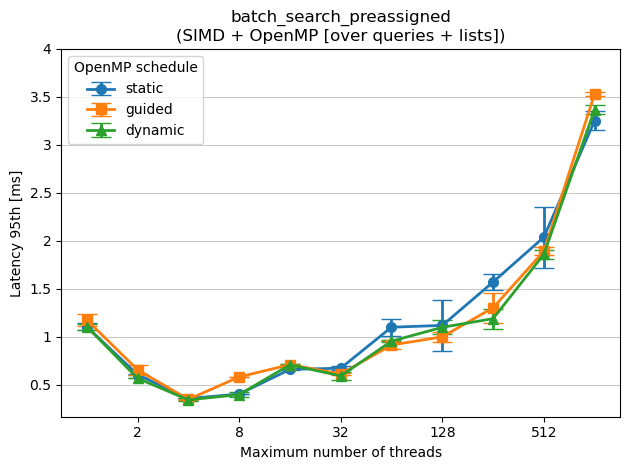

In [48]:
plot(df=threads_latency_df, y_col='latency_95th', yerr_col='latency_95th_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists])', ylabel='Latency 95th [ms]', mode='max_n_threads', yformatter=s_to_ms_formatter, yaxis_top=4e-3, filename='omp-threads-latency-95')

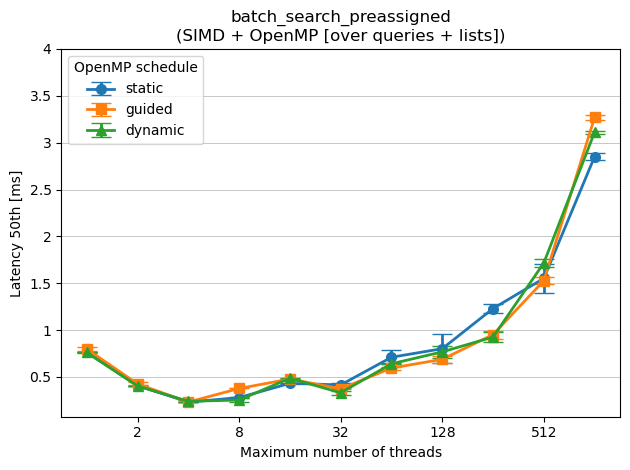

In [49]:
plot(df=threads_latency_df, y_col='latency_50th', yerr_col='latency_50th_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists])', ylabel='Latency 50th [ms]', mode='max_n_threads', yformatter=s_to_ms_formatter, yaxis_top=4e-3, filename='omp-threads-latency-50')

*Service level objective*
- Latency 95th percentile: 1 ms


In [50]:
threads_latency_sla_df = threads_latency_df[threads_latency_df['latency_95th'] <= 1e-3]
threads_latency_sla_df = threads_latency_sla_df.sort_values(by=['latency_95th'])
threads_latency_sla_df

O OMP_SCHEDULE  max_n_threads INSERTION_STRATEGY  MAX_BUFFER_SIZE  \
13  3      dynamic              4            dynamic            10000   
2   3       guided              4            dynamic            10000   
24  3       static              4            dynamic            10000   
14  3      dynamic              8            dynamic            10000   
25  3       static              8            dynamic            10000   
12  3      dynamic              2            dynamic            10000   
3   3       guided              8            dynamic            10000   
16  3      dynamic             32            dynamic            10000   
23  3       static              2            dynamic            10000   
5   3       guided             32            dynamic            10000   
1   3       guided              2            dynamic            10000   
26  3       static             16            dynamic            10000   
27  3       static             32            dynamic            10000   
15  3      dynamic             16            dynamic            10000   
4   3       guided             16            dynamic            10000   
6   3       guided             64            dynamic            10000   
17  3      dynamic             64            dynamic            10000   
7   3       guided            128            dynamic            10000   

    n_lists  n_probes  n_results  latency_50th  latency_50th_std  \
13     1024        16         10      0.000240      1.070100e-05   
2      1024        16         10      0.000232      3.430000e-07   
24     1024        16         10      0.000232      4.890000e-07   
14     1024        16         10      0.000254      2.457600e-05   
25     1024        16         10      0.000280      2.744000e-06   
12     1024        16         10      0.000404      6.300000e-08   
3      1024        16         10      0.000377      3.280000e-07   
16     1024        16         10      0.000331      1.855400e-05   
23     1024        16         10      0.000407      2.390000e-07   
5      1024        16         10      0.000374      3.437000e-06   
1      1024        16         10      0.000426      1.468600e-05   
26     1024        16         10      0.000432      5.149000e-06   
27     1024        16         10      0.000415      2.068800e-05   
15     1024        16         10      0.000486      6.694000e-06   
4      1024        16         10      0.000478      3.534000e-06   
6      1024        16         10      0.000595      1.673200e-05   
17     1024        16         10      0.000641      6.652000e-06   
7      1024        16         10      0.000689      3.469900e-05   

    latency_95th  latency_95th_std  latency_99th  latency_99th_std  
13      0.000342      1.479600e-05      0.000422          0.000019  
2       0.000346      1.698000e-06      0.000443          0.000003  
24      0.000355      2.584000e-06      0.000451          0.000004  
14      0.000396      2.617600e-05      0.000505          0.000023  
25      0.000402      3.766000e-06      0.000503          0.000017  
12      0.000566      7.300000e-07      0.000695          0.000003  
3       0.000581      1.298000e-06      0.000746          0.000004  
16      0.000591      4.401300e-05      0.001907          0.001587  
23      0.000605      8.797000e-06      0.000762          0.000012  
5       0.000612      6.005000e-06      0.000797          0.000007  
1       0.000655      5.037500e-05      0.000816          0.000070  
26      0.000659      6.095000e-06      0.000835          0.000003  
27      0.000672      2.387800e-05      0.001883          0.001234  
15      0.000708      1.210700e-05      0.000868          0.000015  
4       0.000709      8.648000e-06      0.000871          0.000011  
6       0.000913      3.887900e-05      0.001141          0.000065  
17      0.000954      8.557000e-06      0.001199          0.000035  
7       0.000999      5.411600e-05      0.001424          0.000076

In [51]:
threads_throughput_sla_df = threads_throughput_df[(threads_throughput_df['max_n_threads'] >= 2) & (threads_throughput_df['max_n_threads'] <= 32)]
threads_throughput_sla_df = threads_throughput_sla_df.sort_values(by=['mb_per_s'], ascending=False)

threads_throughput_sla_df

O OMP_SCHEDULE  max_n_threads INSERTION_STRATEGY  MAX_BUFFER_SIZE  \
16  3      dynamic             32            dynamic            10000   
15  3      dynamic             16            dynamic            10000   
14  3      dynamic              8            dynamic            10000   
3   3       guided              8            dynamic            10000   
4   3       guided             16            dynamic            10000   
2   3       guided              4            dynamic            10000   
24  3       static              4            dynamic            10000   
13  3      dynamic              4            dynamic            10000   
5   3       guided             32            dynamic            10000   
25  3       static              8            dynamic            10000   
26  3       static             16            dynamic            10000   
27  3       static             32            dynamic            10000   
12  3      dynamic              2            dynamic            10000   
23  3       static              2            dynamic            10000   
1   3       guided              2            dynamic            10000   

    n_lists  n_probes  n_results   time_s  s_per_query  vectors_per_s  \
16     1024        16         10  1.49617     0.000150  668373.246356   
15     1024        16         10  1.54225     0.000154  648403.306857   
14     1024        16         10  1.63379     0.000163  612073.767130   
3      1024        16         10  1.74677     0.000175  572485.215569   
4      1024        16         10  2.07757     0.000208  481331.555615   
2      1024        16         10  2.21595     0.000222  451273.720075   
24     1024        16         10  2.22221     0.000222  450002.475014   
13     1024        16         10  2.22738     0.000223  448957.968555   
5      1024        16         10  2.27134     0.000227  440268.740039   
25     1024        16         10  2.46568     0.000247  405567.632458   
26     1024        16         10  2.68960     0.000269  371802.498513   
27     1024        16         10  3.30015     0.000330  303016.529552   
12     1024        16         10  4.16674     0.000417  239995.776074   
23     1024        16         10  4.18874     0.000419  238735.276002   
1      1024        16         10  4.20760     0.000421  237665.177298   

    queries_per_s  time_s_std  s_per_query_std  vectors_per_s_std  \
16    6683.732464    0.001259     1.258720e-07         562.298918   
15    6484.033069    0.004303     4.302950e-07        1809.075707   
14    6120.737671    0.004886     4.885530e-07        1830.287094   
3     5724.852156    0.146355     1.463550e-05       47966.288478   
4     4813.315556    0.199235     1.992350e-05       46158.778035   
2     4512.737201    0.002095     2.094690e-07         426.579367   
24    4500.024750    0.005112     5.112480e-07        1035.288588   
13    4489.579686    0.006316     6.315730e-07        1273.019112   
5     4402.687400    0.120780     1.207800e-05       23411.580134   
25    4055.676325    0.117329     1.173290e-05       19298.872826   
26    3718.024985    0.378461     3.784610e-05       52317.350308   
27    3030.165296    0.063094     6.309420e-06        5793.247434   
12    2399.957761    0.003490     3.490470e-07         201.043995   
23    2387.352760    0.005824     5.824160e-07         331.945274   
1     2376.651773    0.050218     5.021770e-06        2836.533552   

    queries_per_s_std  size_per_query_mb      mb_per_s  mb_per_s_std  \
16           5.622989           7.629395  50992.831906     42.900003   
15          18.090757           7.629395  49469.246434    138.021523   
14          18.302871           7.629395  46697.522517    139.639823   
3          479.662885           7.629395  43677.155729   3659.537390   
4          461.587780           7.629395  36722.683381   3521.635287   
2            4.265794           7.629395  34429.452520     32.545423   
24          10.352886           7.629395  34332.464219   

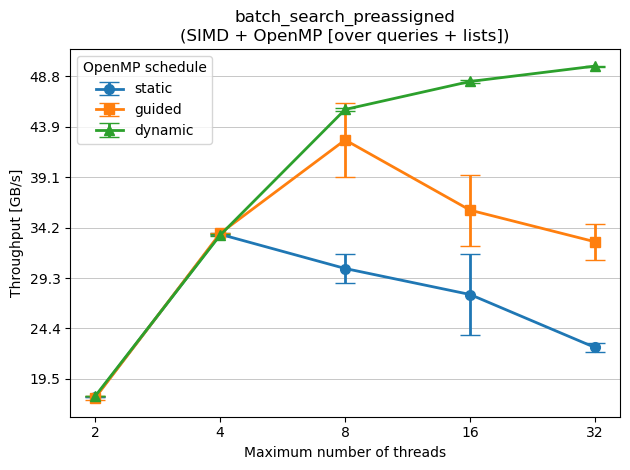

In [52]:
threads_throughput_sla_df = threads_throughput_sla_df.sort_values(by=['OMP_SCHEDULE', 'max_n_threads'])
plot(df=threads_throughput_sla_df, y_col='mb_per_s', yerr_col='mb_per_s_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists])', ylabel='Throughput [GB/s]', mode='max_n_threads', yformatter=mb_to_gb_formatter, scatter=False, filename='omp-threads-throughput-sla')

## `preassign_query()`

In [53]:
centroids_simd_omp_df = results_to_df(merge_results('OpenMP PMODE 1', lambda f: 'throughput' in f and 'preassign_query' in f, 'throughput'), mode='preassign_query')
add_speedup(old_df=centroids_simd_df, new_df=centroids_simd_omp_df, column='mb_per_s')
add_speedup(old_df=centroids_df, new_df=centroids_simd_omp_df, column='mb_per_s', suffix='_speedup_vanilla')
# filter for n_lists=1024, n_probe = 64
# centroids_simd_omp_df = centroids_simd_omp_df[centroids_simd_omp_df['n_lists'] == 1024]
# centroids_simd_omp_df = centroids_simd_omp_df[centroids_simd_omp_df['n_probes'] == 64]
centroids_simd_omp_df

O OMP_SCHEDULE  max_n_threads INSERTION_STRATEGY  MAX_BUFFER_SIZE  \
0   3      dynamic             32            dynamic              100   
1   3      dynamic             32            dynamic              100   
2   3      dynamic             32            dynamic              100   
3   3      dynamic             32            dynamic              100   
4   3      dynamic             32            dynamic              100   
5   3      dynamic             32            dynamic              100   
6   3      dynamic             32            dynamic              100   
7   3      dynamic             32            dynamic              100   
8   3      dynamic             32            dynamic              100   
9   3      dynamic             32            dynamic              100   
10  3      dynamic             32            dynamic              100   
11  3      dynamic             32            dynamic              100   
12  3      dynamic             32            dynamic              100   
13  3      dynamic             32            dynamic              100   
14  3      dynamic             32            dynamic              100   
15  3      dynamic             32            dynamic              100   
16  3      dynamic             32            dynamic              100   
17  3      dynamic             32            dynamic              100   
18  3      dynamic             32            dynamic              100   
19  3      dynamic             32            dynamic              100   
20  3      dynamic             32            dynamic              100   
21  3      dynamic             32            dynamic              100   
22  3      dynamic             32            dynamic              100   
23  3      dynamic             32            dynamic              100   
24  3      dynamic             32            dynamic              100   
25  3      dynamic             32            dynamic              100   
26  3      dynamic             32            dynamic              100   
27  3      dynamic             32            dynamic              100   
28  3      dynamic             32            dynamic              100   
29  3      dynamic             32            dynamic              100   
30  3      dynamic             32            dynamic              100   
31  3      dynamic             32            dynamic              100   
32  3      dynamic             32            dynamic              100   
33  3      dynamic             32            dynamic              100   
34  3      dynamic             32            dynamic              100   
35  3      dynamic             32            dynamic              100   
36  3      dynamic             32            dynamic              100   
37  3      dynamic             32            dynamic              100   
38  3      dynamic             32            dynamic              100   
39  3      dynamic             32            dynamic              100   

    n_lists  n_probes  n_results    time_s   s_per_query  ...  \
0       256         1         10  0.004243  4.242730e-07  ...   
1       256         2         10  0.003722  3.721610e-07  ...   
2       256         4         10  0.004048  4.047510e-07  ...   
3       256         8         10  0.004894  4.894130e-07  ...   
4       256        16         10  0.005554  5.553790e-07  ...   
5       256        32         10  0.006740  6.739910e-07  ...   
6       256        64         10  0.008590  8.590230e-07  ...   
7       256       128         10  0.011078  1.107800e-06  ...   
8       512         1         10  0.007203  7.203230e-07  ...   
9       512         2         10  0.007290  7.289880e-07  ...   
10      512         4         10  0.007425  7.424580e-07  ...   
11      512         8         10  0.007889  7.888990e-07  ...   
12      512        16         10  0.008753  8.752760e-07  ...   
13      512        32         10  0.010271  1.027090e-06  ...   
14      512        64         10  0

In [54]:
centroids_simd_omp_latency_df = results_to_df(merge_results('OpenMP PMODE 1', lambda f: 'latency' in f and 'preassign_query' in f, 'latency'), mode='preassign_query')
add_speedup(old_df=centroids_simd_latency_df, new_df=centroids_simd_omp_latency_df, column='latency_95th', invert=True)
add_speedup(old_df=centroids_latency_df, new_df=centroids_simd_omp_latency_df, column='latency_95th', suffix='_speedup_vanilla', invert=True)
# filter for n_lists=1024, n_probe = 64
# centroids_simd_omp_latency_df = centroids_simd_omp_latency_df[centroids_simd_omp_latency_df['n_lists'] == 1024]
# centroids_simd_omp_latency_df = centroids_simd_omp_latency_df[centroids_simd_omp_latency_df['n_probes'] == 64]
centroids_simd_omp_latency_df

O OMP_SCHEDULE  max_n_threads INSERTION_STRATEGY  MAX_BUFFER_SIZE  \
0   3      dynamic             32            dynamic              100   
1   3      dynamic             32            dynamic              100   
2   3      dynamic             32            dynamic              100   
3   3      dynamic             32            dynamic              100   
4   3      dynamic             32            dynamic              100   
5   3      dynamic             32            dynamic              100   
6   3      dynamic             32            dynamic              100   
7   3      dynamic             32            dynamic              100   
8   3      dynamic             32            dynamic              100   
9   3      dynamic             32            dynamic              100   
10  3      dynamic             32            dynamic              100   
11  3      dynamic             32            dynamic              100   
12  3      dynamic             32            dynamic              100   
13  3      dynamic             32            dynamic              100   
14  3      dynamic             32            dynamic              100   
15  3      dynamic             32            dynamic              100   
16  3      dynamic             32            dynamic              100   
17  3      dynamic             32            dynamic              100   
18  3      dynamic             32            dynamic              100   
19  3      dynamic             32            dynamic              100   
20  3      dynamic             32            dynamic              100   
21  3      dynamic             32            dynamic              100   
22  3      dynamic             32            dynamic              100   
23  3      dynamic             32            dynamic              100   
24  3      dynamic             32            dynamic              100   
25  3      dynamic             32            dynamic              100   
26  3      dynamic             32            dynamic              100   
27  3      dynamic             32            dynamic              100   
28  3      dynamic             32            dynamic              100   
29  3      dynamic             32            dynamic              100   
30  3      dynamic             32            dynamic              100   
31  3      dynamic             32            dynamic              100   
32  3      dynamic             32            dynamic              100   
33  3      dynamic             32            dynamic              100   
34  3      dynamic             32            dynamic              100   
35  3      dynamic             32            dynamic              100   
36  3      dynamic             32            dynamic              100   
37  3      dynamic             32            dynamic              100   
38  3      dynamic             32            dynamic              100   
39  3      dynamic             32            dynamic              100   

    n_lists  n_probes  n_results  latency_50th  latency_50th_std  \
0       256         1         10      0.000021      7.000000e-09   
1       256         2         10      0.000021      5.800000e-08   
2       256         4         10      0.000022      6.900000e-08   
3       256         8         10      0.000023      2.500000e-08   
4       256        16         10      0.000024      1.240000e-07   
5       256        32         10      0.000026      9.200000e-08   
6       256        64         10      0.000032      1.300000e-08   
7       256       128         10      0.000037      4.000000e-08   
8       512         1         10      0.000032      1.600000e-07   
9       512         2         10      0.000032      4.600000e-08   
10      512         4         10      0.000033      1.800000e-08   
11      512         8         10      0.000034      3.800000e-08   
12      512        16         10      0.000036      5.500000e-08   
13      512        32         10      0.000039      1.3000

**Throughput**

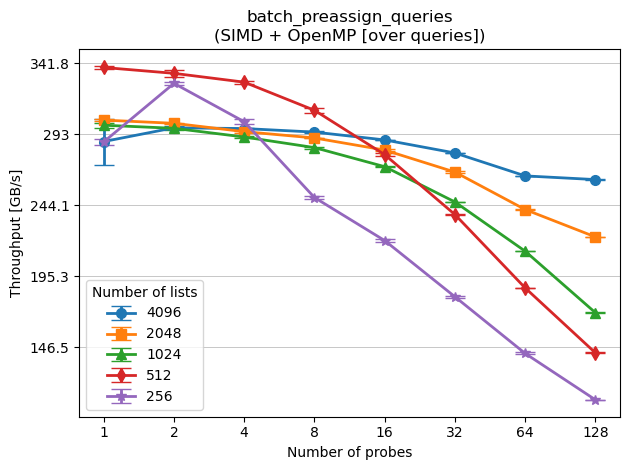

In [55]:
plot(df=centroids_simd_omp_df, y_col='mb_per_s', yerr_col='mb_per_s_std', title='batch_preassign_queries', subtitle='(SIMD + OpenMP [over queries])', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter, filename='omp1-preassign-throughput')

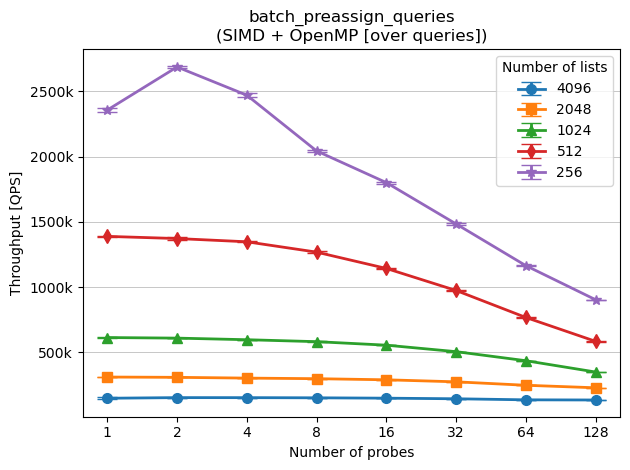

In [56]:
plot(df=centroids_simd_omp_df, y_col='queries_per_s', yerr_col='queries_per_s_std', title='batch_preassign_queries', subtitle='(SIMD + OpenMP [over queries])', ylabel='Throughput [QPS]', yformatter=to_k_formatter)

**Latency**

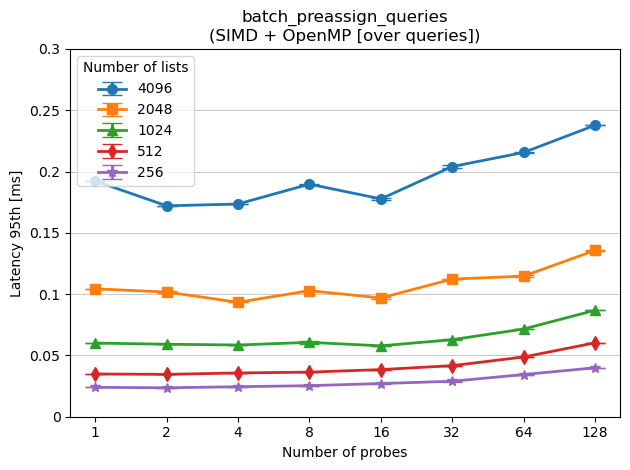

In [57]:
plot(df=centroids_simd_omp_latency_df, y_col='latency_95th', yerr_col='latency_95th_std', title='batch_preassign_queries', subtitle='(SIMD + OpenMP [over queries])', ylabel='Latency 95th [ms]', mode='n_probes', yformatter=s_to_ms_formatter, yaxis_log=False, filename='omp1-preassign-latency-95', yaxis_bottom=0, yaxis_top=.3e-3)

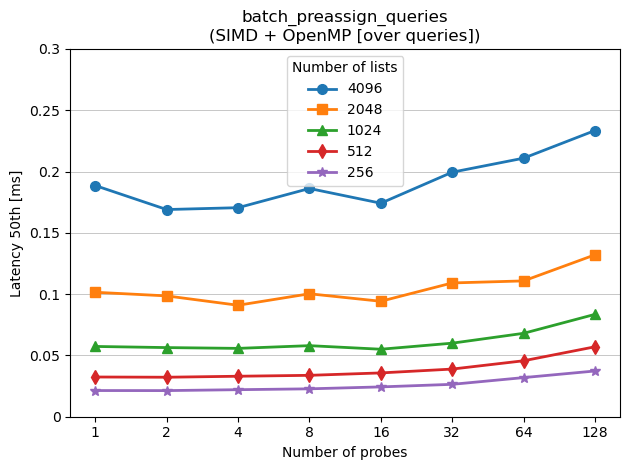

In [58]:
plot(df=centroids_simd_omp_latency_df, y_col='latency_50th', title='batch_preassign_queries', subtitle='(SIMD + OpenMP [over queries])', ylabel='Latency 50th [ms]', mode='n_probes', yformatter=s_to_ms_formatter, yaxis_log=False, filename='omp1-preassign-latency-50', yaxis_bottom=0, yaxis_top=.3e-3)

**Speedup**

Average SIMD + OpenMP speedup over SIMD-only: 19.7x


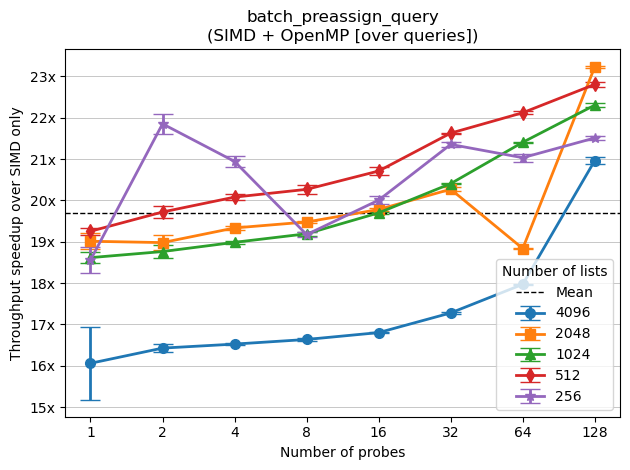

In [59]:
speedup = centroids_simd_omp_df['mb_per_s_speedup'].mean()
print(f'Average SIMD + OpenMP speedup over SIMD-only: {speedup:.1f}x')
plot(df=centroids_simd_omp_df, y_col='mb_per_s_speedup', yerr_col='mb_per_s_speedup_std', title='batch_preassign_query', subtitle='(SIMD + OpenMP [over queries])', ylabel='Throughput speedup over SIMD only', yformatter=speedup_formatter, show_mean=True, filename='omp1-preassign-throughput-speedup')

Average SIMD + OpenMP speedup over Vanilla: 73.1x


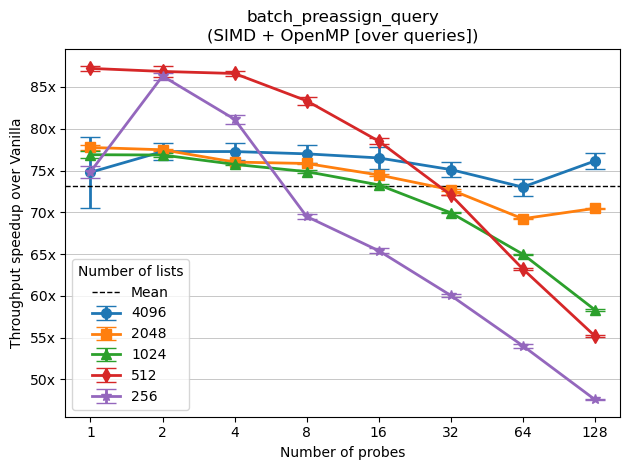

In [60]:
speedup = centroids_simd_omp_df['mb_per_s_speedup_vanilla'].mean()
print(f'Average SIMD + OpenMP speedup over Vanilla: {speedup:.1f}x')
plot(df=centroids_simd_omp_df, y_col='mb_per_s_speedup_vanilla', yerr_col='mb_per_s_speedup_vanilla_std', title='batch_preassign_query', subtitle='(SIMD + OpenMP [over queries])', ylabel='Throughput speedup over Vanilla', yformatter=speedup_formatter, show_mean=True)

Average SIMD + OpenMP [over queries] latency 95th speedup over SIMD-only: 0.5x


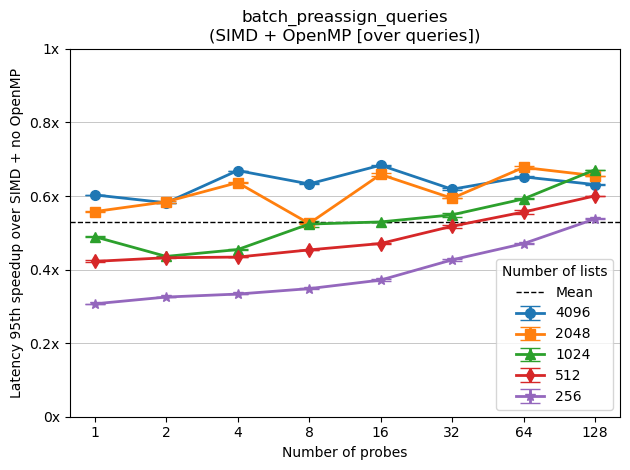

In [61]:
speedup = centroids_simd_omp_latency_df['latency_95th_speedup'].mean()
print(f'Average SIMD + OpenMP [over queries] latency 95th speedup over SIMD-only: {speedup:.1f}x')
plot(df=centroids_simd_omp_latency_df, y_col='latency_95th_speedup', yerr_col='latency_95th_speedup_std', title='batch_preassign_queries', subtitle='(SIMD + OpenMP [over queries])', ylabel='Latency 95th speedup over SIMD + no OpenMP', show_mean=True, yformatter=speedup_formatter, filename='omp1-preassign-latency-95-speedup', yaxis_bottom=0, yaxis_top=1)

Average SIMD + OpenMP [over queries] latency 95th over Vanilla: 2.1x


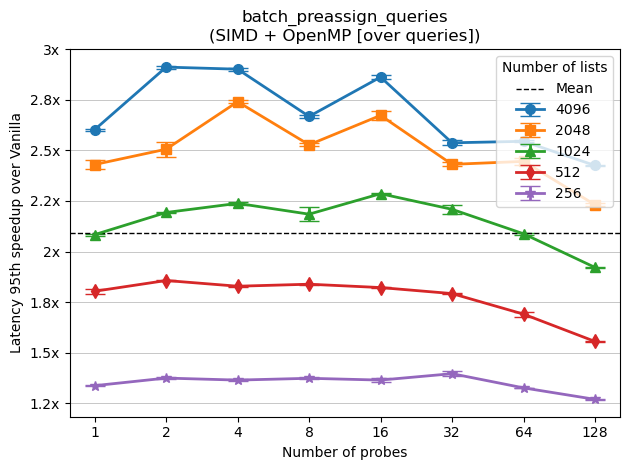

In [62]:
speedup = centroids_simd_omp_latency_df['latency_95th_speedup_vanilla'].mean()
print(f'Average SIMD + OpenMP [over queries] latency 95th over Vanilla: {speedup:.1f}x')
plot(df=centroids_simd_omp_latency_df, y_col='latency_95th_speedup_vanilla', yerr_col='latency_95th_speedup_vanilla_std', title='batch_preassign_queries', subtitle='(SIMD + OpenMP [over queries])', ylabel='Latency 95th speedup over Vanilla', show_mean=True, yformatter=speedup_formatter)

## `search_preassigned()`

In [63]:
search_simd_omp_df = results_to_df(merge_results('OpenMP PMODE 1', lambda f: 'throughput' in f and 'search_preassigned' in f, 'throughput'), mode='search_preassigned')
add_speedup(old_df=search_simd_df, new_df=search_simd_omp_df, column='mb_per_s')
add_speedup(old_df=search_df, new_df=search_simd_omp_df, column='mb_per_s', suffix='_speedup_vanilla')
search_simd_omp_df

O OMP_SCHEDULE  max_n_threads INSERTION_STRATEGY  MAX_BUFFER_SIZE  \
0   3      dynamic             32            dynamic              100   
1   3      dynamic             32            dynamic              100   
2   3      dynamic             32            dynamic              100   
3   3      dynamic             32            dynamic              100   
4   3      dynamic             32            dynamic              100   
5   3      dynamic             32            dynamic              100   
6   3      dynamic             32            dynamic              100   
7   3      dynamic             32            dynamic              100   
8   3      dynamic             32            dynamic              100   
9   3      dynamic             32            dynamic              100   
10  3      dynamic             32            dynamic              100   
11  3      dynamic             32            dynamic              100   
12  3      dynamic             32            dynamic              100   
13  3      dynamic             32            dynamic              100   
14  3      dynamic             32            dynamic              100   
15  3      dynamic             32            dynamic              100   
16  3      dynamic             32            dynamic              100   
17  3      dynamic             32            dynamic              100   
18  3      dynamic             32            dynamic              100   
19  3      dynamic             32            dynamic              100   
20  3      dynamic             32            dynamic              100   
21  3      dynamic             32            dynamic              100   
22  3      dynamic             32            dynamic              100   
23  3      dynamic             32            dynamic              100   
24  3      dynamic             32            dynamic              100   
25  3      dynamic             32            dynamic              100   
26  3      dynamic             32            dynamic              100   
27  3      dynamic             32            dynamic              100   
28  3      dynamic             32            dynamic              100   
29  3      dynamic             32            dynamic              100   
30  3      dynamic             32            dynamic              100   
31  3      dynamic             32            dynamic              100   
32  3      dynamic             32            dynamic              100   
33  3      dynamic             32            dynamic              100   
34  3      dynamic             32            dynamic              100   
35  3      dynamic             32            dynamic              100   
36  3      dynamic             32            dynamic              100   
37  3      dynamic             32            dynamic              100   
38  3      dynamic             32            dynamic              100   
39  3      dynamic             32            dynamic              100   

    n_lists  n_probes  n_results     time_s  s_per_query  ...  \
0       256         1         10   0.373405     0.000037  ...   
1       256         2         10   0.744453     0.000074  ...   
2       256         4         10   2.529990     0.000253  ...   
3       256         8         10   4.978250     0.000498  ...   
4       256        16         10   5.991300     0.000599  ...   
5       256        32         10  11.172900     0.001117  ...   
6       256        64         10  21.434500     0.002143  ...   
7       256       128         10  43.627200     0.004363  ...   
8       512         1         10   0.190249     0.000019  ...   
9       512         2         10   0.373046     0.000037  ...   
10      512         4         10   0.752057     0.000075  ...   
11      512         8         10   1.506460     0.000151  ...   
12      512        16         10   2.854280     0.000285  ...   
13      512        32         10   5.842010     0.000584  ...   
14      512        64         10  1

In [64]:
search_simd_omp_latency_df = results_to_df(merge_results('OpenMP PMODE 1', lambda f: 'latency' in f and 'search_preassigned' in f, 'latency'), mode='search_preassigned')
add_speedup(old_df=search_simd_latency_df, new_df=search_simd_omp_latency_df, column='latency_95th', invert=True)
add_speedup(old_df=search_latency_df, new_df=search_simd_omp_latency_df, column='latency_95th', suffix='_speedup_vanilla', invert=True)
search_simd_omp_latency_df

O OMP_SCHEDULE  max_n_threads INSERTION_STRATEGY  MAX_BUFFER_SIZE  \
0   3      dynamic             32            dynamic              100   
1   3      dynamic             32            dynamic              100   
2   3      dynamic             32            dynamic              100   
3   3      dynamic             32            dynamic              100   
4   3      dynamic             32            dynamic              100   
5   3      dynamic             32            dynamic              100   
6   3      dynamic             32            dynamic              100   
7   3      dynamic             32            dynamic              100   
8   3      dynamic             32            dynamic              100   
9   3      dynamic             32            dynamic              100   
10  3      dynamic             32            dynamic              100   
11  3      dynamic             32            dynamic              100   
12  3      dynamic             32            dynamic              100   
13  3      dynamic             32            dynamic              100   
14  3      dynamic             32            dynamic              100   
15  3      dynamic             32            dynamic              100   
16  3      dynamic             32            dynamic              100   
17  3      dynamic             32            dynamic              100   
18  3      dynamic             32            dynamic              100   
19  3      dynamic             32            dynamic              100   
20  3      dynamic             32            dynamic              100   
21  3      dynamic             32            dynamic              100   
22  3      dynamic             32            dynamic              100   
23  3      dynamic             32            dynamic              100   
24  3      dynamic             32            dynamic              100   
25  3      dynamic             32            dynamic              100   
26  3      dynamic             32            dynamic              100   
27  3      dynamic             32            dynamic              100   
28  3      dynamic             32            dynamic              100   
29  3      dynamic             32            dynamic              100   
30  3      dynamic             32            dynamic              100   
31  3      dynamic             32            dynamic              100   
32  3      dynamic             32            dynamic              100   
33  3      dynamic             32            dynamic              100   
34  3      dynamic             32            dynamic              100   
35  3      dynamic             32            dynamic              100   
36  3      dynamic             32            dynamic              100   
37  3      dynamic             32            dynamic              100   
38  3      dynamic             32            dynamic              100   
39  3      dynamic             32            dynamic              100   

    n_lists  n_probes  n_results  latency_50th  latency_50th_std  \
0       256         1         10      0.000232      2.040000e-07   
1       256         2         10      0.000452      6.332000e-06   
2       256         4         10      0.001035      1.234200e-05   
3       256         8         10      0.001872      1.067860e-04   
4       256        16         10      0.003175      1.383000e-06   
5       256        32         10      0.006105      2.018230e-04   
6       256        64         10      0.012493      6.532660e-04   
7       256       128         10      0.025505      2.336267e-03   
8       512         1         10      0.000126      7.140000e-07   
9       512         2         10      0.000237      7.700000e-08   
10      512         4         10      0.000454      1.592000e-06   
11      512         8         10      0.000956      5.934000e-05   
12      512        16         10      0.001852      1.680510e-04   
13      512        32         10      0.004080      5.8358

**Throughput**

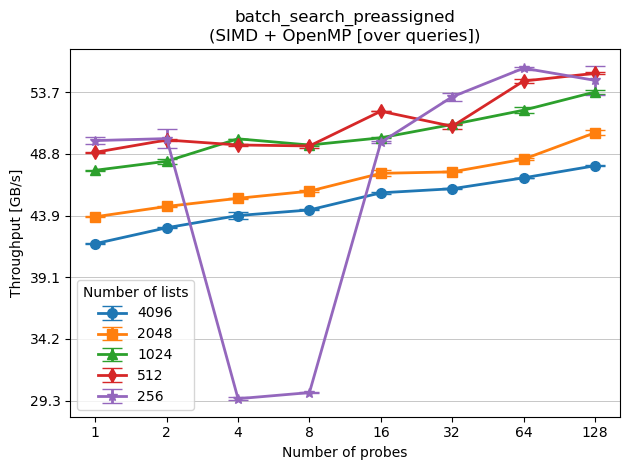

In [65]:
plot(df=search_simd_omp_df, y_col='mb_per_s', yerr_col='mb_per_s_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries])', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter, filename='omp1-search-throughput')

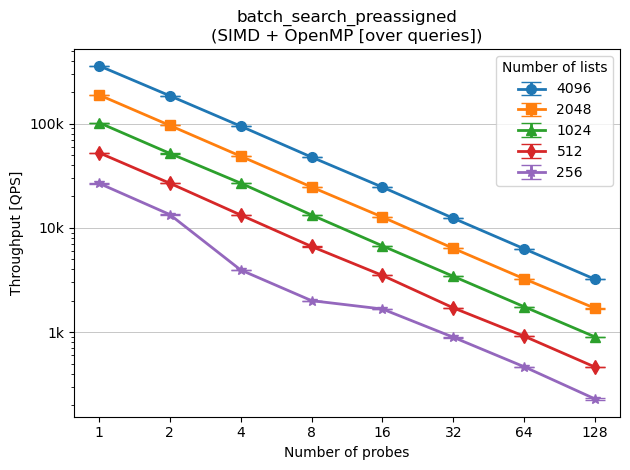

In [66]:
plot(df=search_simd_omp_df, y_col='queries_per_s', yerr_col='queries_per_s_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries])', ylabel='Throughput [QPS]', yformatter=to_k_formatter, filename='omp1-search-throughput-qps', yaxis_log=True)

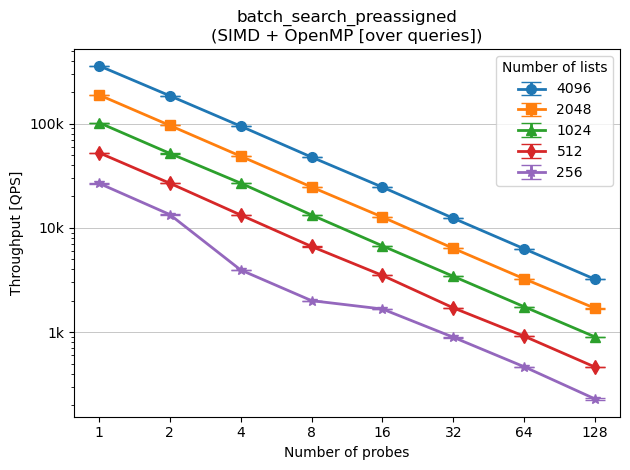

In [67]:
plot(df=search_simd_omp_df, y_col='queries_per_s', yerr_col='queries_per_s_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries])', ylabel='Throughput [QPS]', yformatter=to_k_formatter, yaxis_log=True)

**Latency**

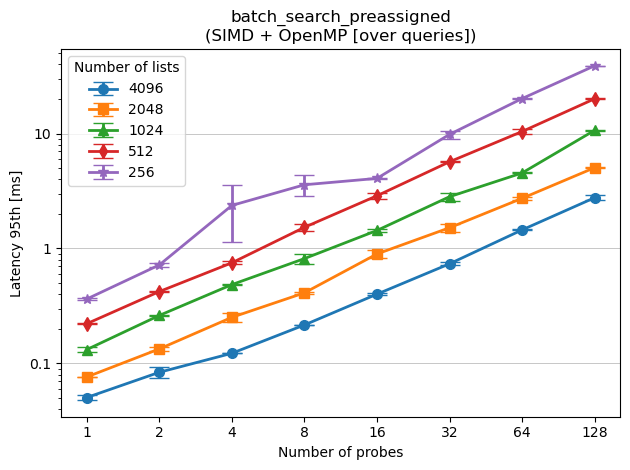

In [68]:
plot(df=search_simd_omp_latency_df, y_col='latency_95th', yerr_col='latency_95th_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries])', ylabel='Latency 95th [ms]', mode='n_probes', yformatter=s_to_ms_formatter, yaxis_log=True, filename='omp1-search-latency-95')

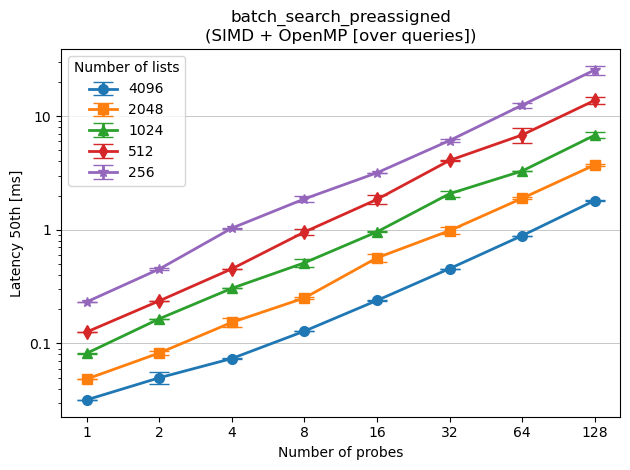

In [69]:
plot(df=search_simd_omp_latency_df, y_col='latency_50th', yerr_col='latency_50th_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries])', ylabel='Latency 50th [ms]', mode='n_probes', yformatter=s_to_ms_formatter, yaxis_log=True, filename='omp1-search-latency-50')

**Speedup**

Average SIMD + OpenMP speedup over SIMD-only: 4.8x


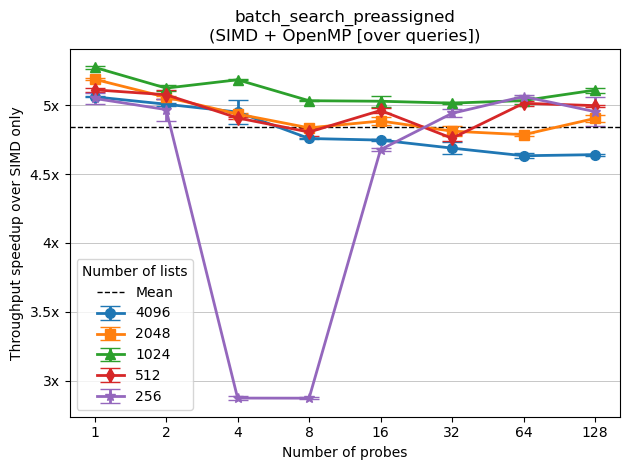

In [70]:
speedup = search_simd_omp_df['mb_per_s_speedup'].mean()
print(f'Average SIMD + OpenMP speedup over SIMD-only: {speedup:.1f}x')
plot(df=search_simd_omp_df, y_col='mb_per_s_speedup', yerr_col='mb_per_s_speedup_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries])', ylabel='Throughput speedup over SIMD only', yformatter=speedup_formatter, show_mean=True, filename='omp1-search-throughput-speedup')

Average SIMD + OpenMP speedup over Vanilla: 13.3x


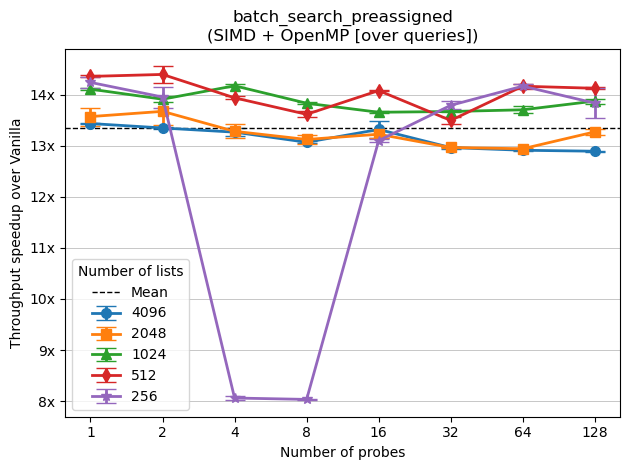

In [71]:
speedup = search_simd_omp_df['mb_per_s_speedup_vanilla'].mean()
print(f'Average SIMD + OpenMP speedup over Vanilla: {speedup:.1f}x')
plot(df=search_simd_omp_df, y_col='mb_per_s_speedup_vanilla', yerr_col='mb_per_s_speedup_vanilla_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries])', ylabel='Throughput speedup over Vanilla', yformatter=speedup_formatter, show_mean=True)

Average SIMD + OpenMP [over queries] latency 95th speedup over SIMD-only: 0.7x


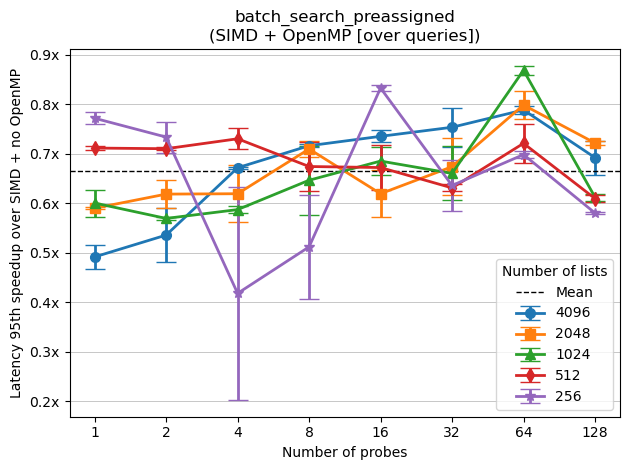

In [72]:
speedup = search_simd_omp_latency_df['latency_95th_speedup'].mean()
print(f'Average SIMD + OpenMP [over queries] latency 95th speedup over SIMD-only: {speedup:.1f}x')
plot(df=search_simd_omp_latency_df, y_col='latency_95th_speedup', yerr_col='latency_95th_speedup_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries])', ylabel='Latency 95th speedup over SIMD + no OpenMP', show_mean=True, yformatter=speedup_formatter, filename='omp1-search-latency-95-speedup', yaxis_log=False)

Average SIMD + OpenMP [over queries] latency 95th speedup over Vanilla: 1.8x


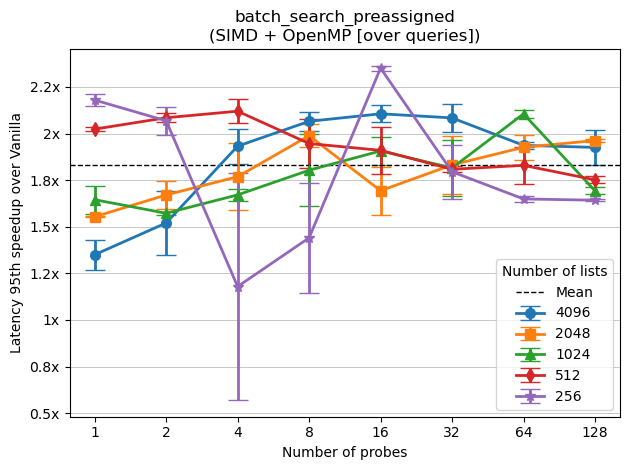

In [73]:
speedup = search_simd_omp_latency_df['latency_95th_speedup_vanilla'].mean()
print(f'Average SIMD + OpenMP [over queries] latency 95th speedup over Vanilla: {speedup:.1f}x')
plot(df=search_simd_omp_latency_df, y_col='latency_95th_speedup_vanilla', yerr_col='latency_95th_speedup_vanilla_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries])', ylabel='Latency 95th speedup over Vanilla', show_mean=True, yformatter=speedup_formatter)

# SIMD, OpenMP (over queries and lists)

## `search_preassigned()`

In [74]:
directory = 'OpenMP PMODE 2'
search_simd_omp_pmode2_df = results_to_df(merge_results(directory, lambda f: 'search_preassigned' in f and 'throughput' in f, 'throughput'), mode="search_preassigned")
add_speedup(old_df=search_simd_omp_df, new_df=search_simd_omp_pmode2_df, column='mb_per_s')
add_speedup(old_df=search_df, new_df=search_simd_omp_pmode2_df, column='mb_per_s', suffix='_speedup_vanilla')
# search_simd_omp_pmode2_df = search_simd_omp_pmode2_df[search_simd_omp_pmode2_df['n_lists'] == 1024]
# search_simd_omp_pmode2_df = search_simd_omp_pmode2_df[search_simd_omp_pmode2_df['n_probes'] == 128]
search_simd_omp_pmode2_df.to_csv(join('benchmarks', directory, 'search.csv'), index=False)
search_simd_omp_pmode2_df

O OMP_SCHEDULE  max_n_threads INSERTION_STRATEGY  MAX_BUFFER_SIZE  \
0   3      dynamic             32            dynamic              100   
1   3      dynamic             32            dynamic              100   
2   3      dynamic             32            dynamic              100   
3   3      dynamic             32            dynamic              100   
4   3      dynamic             32            dynamic              100   
5   3      dynamic             32            dynamic              100   
6   3      dynamic             32            dynamic              100   
7   3      dynamic             32            dynamic              100   
8   3      dynamic             32            dynamic              100   
9   3      dynamic             32            dynamic              100   
10  3      dynamic             32            dynamic              100   
11  3      dynamic             32            dynamic              100   
12  3      dynamic             32            dynamic              100   
13  3      dynamic             32            dynamic              100   
14  3      dynamic             32            dynamic              100   
15  3      dynamic             32            dynamic              100   
16  3      dynamic             32            dynamic              100   
17  3      dynamic             32            dynamic              100   
18  3      dynamic             32            dynamic              100   
19  3      dynamic             32            dynamic              100   
20  3      dynamic             32            dynamic              100   
21  3      dynamic             32            dynamic              100   
22  3      dynamic             32            dynamic              100   
23  3      dynamic             32            dynamic              100   
24  3      dynamic             32            dynamic              100   
25  3      dynamic             32            dynamic              100   
26  3      dynamic             32            dynamic              100   
27  3      dynamic             32            dynamic              100   
28  3      dynamic             32            dynamic              100   
29  3      dynamic             32            dynamic              100   
30  3      dynamic             32            dynamic              100   
31  3      dynamic             32            dynamic              100   
32  3      dynamic             32            dynamic              100   
33  3      dynamic             32            dynamic              100   
34  3      dynamic             32            dynamic              100   
35  3      dynamic             32            dynamic              100   
36  3      dynamic             32            dynamic              100   
37  3      dynamic             32            dynamic              100   
38  3      dynamic             32            dynamic              100   
39  3      dynamic             32            dynamic              100   

    n_lists  n_probes  n_results     time_s  s_per_query  ...  \
0       256         1         10   0.375460     0.000038  ...   
1       256         2         10   0.754428     0.000075  ...   
2       256         4         10   1.492850     0.000149  ...   
3       256         8         10   2.878820     0.000288  ...   
4       256        16         10   5.686060     0.000569  ...   
5       256        32         10  11.701700     0.001170  ...   
6       256        64         10  29.895300     0.002990  ...   
7       256       128         10  61.866600     0.006187  ...   
8       512         1         10   0.192560     0.000019  ...   
9       512         2         10   0.379700     0.000038  ...   
10      512         4         10   0.740336     0.000074  ...   
11      512         8         10   1.458720     0.000146  ...   
12      512        16         10   2.882300     0.000288  ...   
13      512        32         10   5.716380     0.000572  ...   
14      512        64         10  1

In [75]:
directory = 'OpenMP PMODE 2'
search_simd_omp_pmode2_latency_df = results_to_df(merge_results(directory, lambda f: 'search_preassigned' in f and 'latency' in f, 'latency'), mode="search_preassigned")
add_speedup(old_df=search_simd_omp_latency_df, new_df=search_simd_omp_pmode2_latency_df, column='latency_95th', invert=True)
add_speedup(old_df=search_latency_df, new_df=search_simd_omp_pmode2_latency_df, column='latency_95th', suffix='_speedup_vanilla', invert=True)
search_simd_omp_pmode2_latency_df.to_csv(join('benchmarks', directory, 'search_latency.csv'), index=False)
search_simd_omp_pmode2_latency_df

O OMP_SCHEDULE  max_n_threads INSERTION_STRATEGY  MAX_BUFFER_SIZE  \
0   3      dynamic             32            dynamic              100   
1   3      dynamic             32            dynamic              100   
2   3      dynamic             32            dynamic              100   
3   3      dynamic             32            dynamic              100   
4   3      dynamic             32            dynamic              100   
5   3      dynamic             32            dynamic              100   
6   3      dynamic             32            dynamic              100   
7   3      dynamic             32            dynamic              100   
8   3      dynamic             32            dynamic              100   
9   3      dynamic             32            dynamic              100   
10  3      dynamic             32            dynamic              100   
11  3      dynamic             32            dynamic              100   
12  3      dynamic             32            dynamic              100   
13  3      dynamic             32            dynamic              100   
14  3      dynamic             32            dynamic              100   
15  3      dynamic             32            dynamic              100   
16  3      dynamic             32            dynamic              100   
17  3      dynamic             32            dynamic              100   
18  3      dynamic             32            dynamic              100   
19  3      dynamic             32            dynamic              100   
20  3      dynamic             32            dynamic              100   
21  3      dynamic             32            dynamic              100   
22  3      dynamic             32            dynamic              100   
23  3      dynamic             32            dynamic              100   
24  3      dynamic             32            dynamic              100   
25  3      dynamic             32            dynamic              100   
26  3      dynamic             32            dynamic              100   
27  3      dynamic             32            dynamic              100   
28  3      dynamic             32            dynamic              100   
29  3      dynamic             32            dynamic              100   
30  3      dynamic             32            dynamic              100   
31  3      dynamic             32            dynamic              100   
32  3      dynamic             32            dynamic              100   
33  3      dynamic             32            dynamic              100   
34  3      dynamic             32            dynamic              100   
35  3      dynamic             32            dynamic              100   
36  3      dynamic             32            dynamic              100   
37  3      dynamic             32            dynamic              100   
38  3      dynamic             32            dynamic              100   
39  3      dynamic             32            dynamic              100   

    n_lists  n_probes  n_results  latency_50th  latency_50th_std  \
0       256         1         10      0.000251      2.204000e-06   
1       256         2         10      0.000307      1.092000e-06   
2       256         4         10      0.000485      4.355500e-05   
3       256         8         10      0.001006      1.196160e-04   
4       256        16         10      0.001676      8.450900e-05   
5       256        32         10      0.002718      2.092200e-04   
6       256        64         10      0.004172      4.382400e-05   
7       256       128         10      0.006993      3.017700e-05   
8       512         1         10      0.000154      7.700000e-08   
9       512         2         10      0.000163      1.920000e-07   
10      512         4         10      0.000243      3.890000e-06   
11      512         8         10      0.000409      1.656000e-06   
12      512        16         10      0.001065      6.736600e-05   
13      512        32         10      0.001581      2.5745

**Throughput**

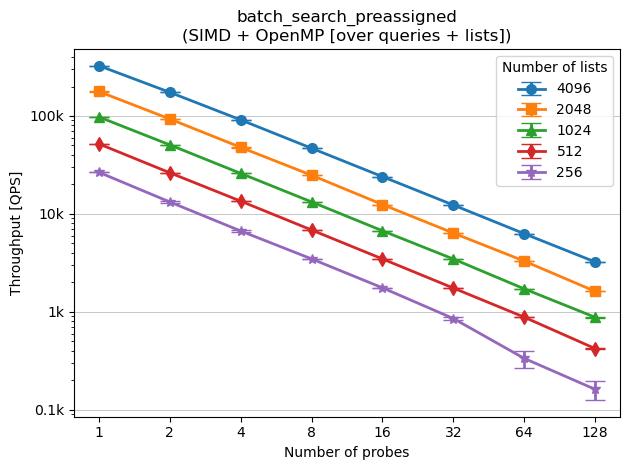

In [76]:
plot(df=search_simd_omp_pmode2_df, y_col='queries_per_s', yerr_col='queries_per_s_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists])', ylabel='Throughput [QPS]', yformatter=to_k_formatter, yaxis_log=True, filename='omp2-search-throughput-qps')

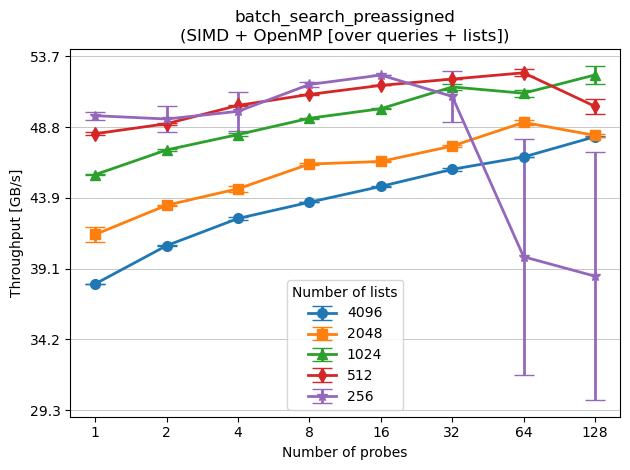

In [77]:
plot(df=search_simd_omp_pmode2_df, y_col='mb_per_s', yerr_col='mb_per_s_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists])', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter, filename='omp2-search-throughput')

**Latency**

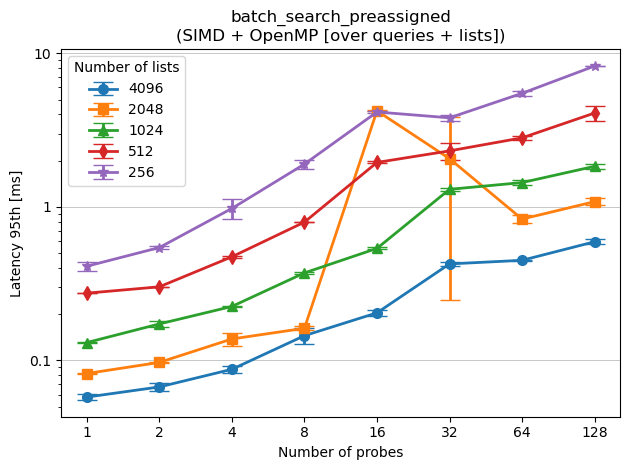

In [78]:
plot(df=search_simd_omp_pmode2_latency_df, y_col='latency_95th', yerr_col='latency_95th_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists])', ylabel='Latency 95th [ms]', mode='n_probes', yformatter=s_to_ms_formatter, yaxis_log=True, filename='omp2-search-latency-95')

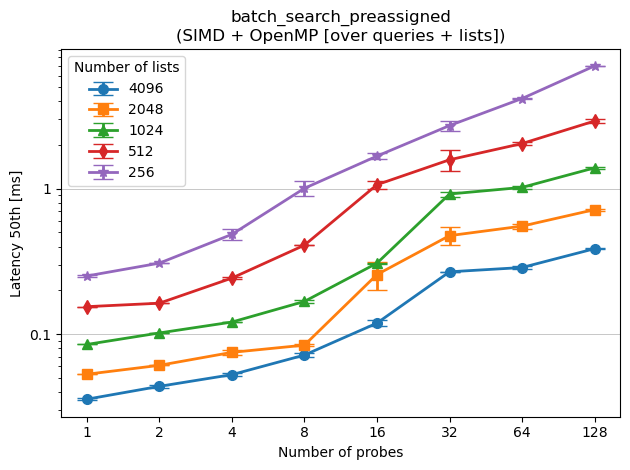

In [79]:
plot(df=search_simd_omp_pmode2_latency_df, y_col='latency_50th', yerr_col='latency_50th_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists])', ylabel='Latency 50th [ms]', mode='n_probes', yformatter=s_to_ms_formatter, yaxis_log=True, filename='omp2-search-latency-50')

**Speedup**

Average SIMD + OpenMP [over queries + lists] speedup over queries-only: 1.0x


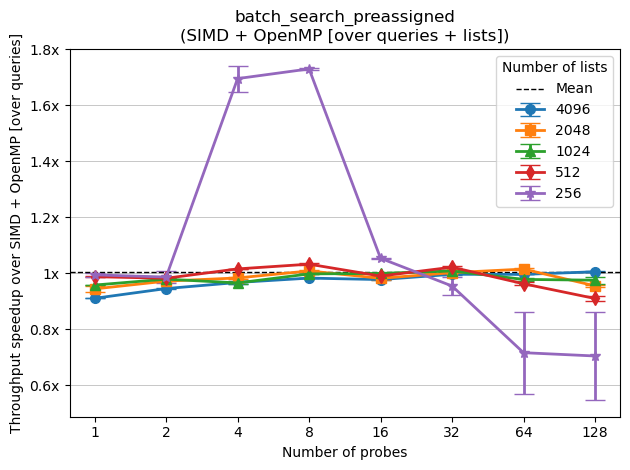

In [80]:
speedup = search_simd_omp_pmode2_df['mb_per_s_speedup'].mean()
print(f'Average SIMD + OpenMP [over queries + lists] speedup over queries-only: {speedup:.1f}x')
plot(df=search_simd_omp_pmode2_df, y_col='mb_per_s_speedup', yerr_col='mb_per_s_speedup_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists])', ylabel='Throughput speedup over SIMD + OpenMP [over queries]', yformatter=speedup_formatter, show_mean=True, filename='omp2-search-throughput-speedup',)

Average SIMD + OpenMP [over queries + lists] speedup over Vanilla: 13.2x


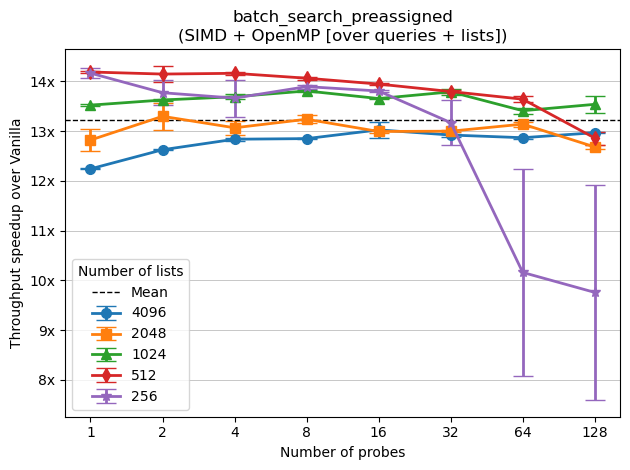

In [81]:
speedup = search_simd_omp_pmode2_df['mb_per_s_speedup_vanilla'].mean()
print(f'Average SIMD + OpenMP [over queries + lists] speedup over Vanilla: {speedup:.1f}x')
plot(df=search_simd_omp_pmode2_df, y_col='mb_per_s_speedup_vanilla', yerr_col='mb_per_s_speedup_vanilla_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists])', ylabel='Throughput speedup over Vanilla', yformatter=speedup_formatter, show_mean=True, filename='omp2-search-throughput-speedup-vanilla')

Average SIMD + OpenMP [over queries + lists] latency 95th speedup over queries-only: 2.2x


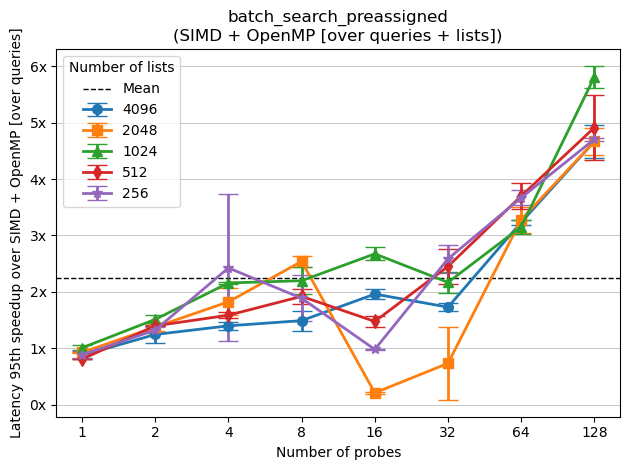

In [82]:
speedup = search_simd_omp_pmode2_latency_df['latency_95th_speedup'].mean()
print(f'Average SIMD + OpenMP [over queries + lists] latency 95th speedup over queries-only: {speedup:.1f}x')
plot(df=search_simd_omp_pmode2_latency_df, y_col='latency_95th_speedup', yerr_col='latency_95th_speedup_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists])', ylabel='Latency 95th speedup over SIMD + OpenMP [over queries]', show_mean=True, yformatter=speedup_formatter, filename='omp2-search-latency-95-speedup')

Average SIMD + OpenMP [over queries + lists] latency 95th speedup over Vanilla: 4.1x


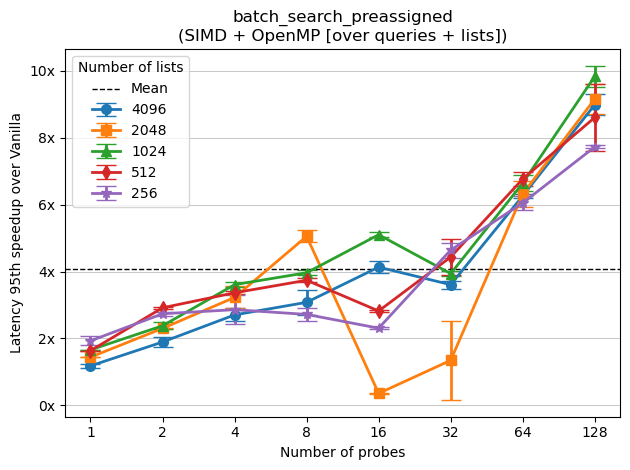

In [83]:
speedup = search_simd_omp_pmode2_latency_df['latency_95th_speedup_vanilla'].mean()
print(f'Average SIMD + OpenMP [over queries + lists] latency 95th speedup over Vanilla: {speedup:.1f}x')
plot(df=search_simd_omp_pmode2_latency_df, y_col='latency_95th_speedup_vanilla', yerr_col='latency_95th_speedup_vanilla_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists])', ylabel='Latency 95th speedup over Vanilla', show_mean=True, yformatter=speedup_formatter, filename='omp2-search-latency-95-speedup-vanilla')

### Varying `n_probes` and `n_results`

In [84]:
search_simd_omp_pmode2_varying_nresults_df = results_to_df(merge_results('number of results', lambda f: 'search_preassigned' in f and 'throughput' in f, 'throughput'), mode="search_preassigned")
search_simd_omp_pmode2_varying_nresults_df = search_simd_omp_pmode2_varying_nresults_df[search_simd_omp_pmode2_varying_nresults_df['n_probes'].isin([1, 4, 16, 64])]
search_simd_omp_pmode2_varying_nresults_df

O OMP_SCHEDULE  max_n_threads INSERTION_STRATEGY  MAX_BUFFER_SIZE  \
0   3      dynamic             32            dynamic              100   
1   3      dynamic             32            dynamic              100   
2   3      dynamic             32            dynamic              100   
3   3      dynamic             32            dynamic              100   
4   3      dynamic             32            dynamic              100   
5   3      dynamic             32            dynamic              100   
6   3      dynamic             32            dynamic              100   
7   3      dynamic             32            dynamic              100   
16  3      dynamic             32            dynamic              100   
17  3      dynamic             32            dynamic              100   
18  3      dynamic             32            dynamic              100   
19  3      dynamic             32            dynamic              100   
20  3      dynamic             32            dynamic              100   
21  3      dynamic             32            dynamic              100   
22  3      dynamic             32            dynamic              100   
23  3      dynamic             32            dynamic              100   
32  3      dynamic             32            dynamic              100   
33  3      dynamic             32            dynamic              100   
34  3      dynamic             32            dynamic              100   
35  3      dynamic             32            dynamic              100   
36  3      dynamic             32            dynamic              100   
37  3      dynamic             32            dynamic              100   
38  3      dynamic             32            dynamic              100   
39  3      dynamic             32            dynamic              100   
48  3      dynamic             32            dynamic              100   
49  3      dynamic             32            dynamic              100   
50  3      dynamic             32            dynamic              100   
51  3      dynamic             32            dynamic              100   
52  3      dynamic             32            dynamic              100   
53  3      dynamic             32            dynamic              100   
54  3      dynamic             32            dynamic              100   
55  3      dynamic             32            dynamic              100   

    n_lists  n_probes  n_results    time_s  s_per_query  vectors_per_s  \
0      1024         1          1  0.098694     0.000010   1.013238e+07   
1      1024         1          2  0.101316     0.000010   9.870109e+06   
2      1024         1          4  0.099994     0.000010   1.000062e+07   
3      1024         1          8  0.100421     0.000010   9.958076e+06   
4      1024         1         16  0.102033     0.000010   9.800751e+06   
5      1024         1         32  0.105684     0.000011   9.462170e+06   
6      1024         1         64  0.113424     0.000011   8.816476e+06   
7      1024         1        128  0.169137     0.000017   5.912367e+06   
16     1024         4          1  0.383252     0.000038   2.609249e+06   
17     1024         4          2  0.387939     0.000039   2.577725e+06   
18     1024         4          4  0.384840     0.000038   2.598482e+06   
19     1024         4          8  0.646845     0.000065   1.545965e+06   
20     1024         4         16  0.386639     0.000039   2.586392e+06   
21     1024         4         32  0.396631     0.000040   2.521235e+06   
22     1024         4         64  0.413563     0.000041   2.418011e+06   
23     1024         4        128  0.703766     0.000070   1.420927e+06   
32     1024        16          1  1.503260     0.000150   6.652209e+05   
33     1024        16          2  1.487960     0.000149   6.720611e+05   
34     1024        16          4  1.493530     0.000149   6.695547e+05   
35     1024        16          8  1.483750     0.000148   6.739680e+05   
36     1024        16         16  1.4840

In [85]:
search_simd_omp_pmode2_varying_nresults_latency_df = results_to_df(merge_results('number of results', lambda f: 'search_preassigned' in f and 'latency' in f, 'latency'), mode="search_preassigned")
search_simd_omp_pmode2_varying_nresults_latency_df = search_simd_omp_pmode2_varying_nresults_latency_df[search_simd_omp_pmode2_varying_nresults_latency_df['n_probes'].isin([1, 4, 16, 64])]
search_simd_omp_pmode2_varying_nresults_latency_df

O OMP_SCHEDULE  max_n_threads INSERTION_STRATEGY  MAX_BUFFER_SIZE  \
0   3      dynamic             32            dynamic              100   
1   3      dynamic             32            dynamic              100   
2   3      dynamic             32            dynamic              100   
3   3      dynamic             32            dynamic              100   
4   3      dynamic             32            dynamic              100   
5   3      dynamic             32            dynamic              100   
6   3      dynamic             32            dynamic              100   
7   3      dynamic             32            dynamic              100   
16  3      dynamic             32            dynamic              100   
17  3      dynamic             32            dynamic              100   
18  3      dynamic             32            dynamic              100   
19  3      dynamic             32            dynamic              100   
20  3      dynamic             32            dynamic              100   
21  3      dynamic             32            dynamic              100   
22  3      dynamic             32            dynamic              100   
23  3      dynamic             32            dynamic              100   
32  3      dynamic             32            dynamic              100   
33  3      dynamic             32            dynamic              100   
34  3      dynamic             32            dynamic              100   
35  3      dynamic             32            dynamic              100   
36  3      dynamic             32            dynamic              100   
37  3      dynamic             32            dynamic              100   
38  3      dynamic             32            dynamic              100   
39  3      dynamic             32            dynamic              100   
48  3      dynamic             32            dynamic              100   
49  3      dynamic             32            dynamic              100   
50  3      dynamic             32            dynamic              100   
51  3      dynamic             32            dynamic              100   
52  3      dynamic             32            dynamic              100   
53  3      dynamic             32            dynamic              100   
54  3      dynamic             32            dynamic              100   
55  3      dynamic             32            dynamic              100   

    n_lists  n_probes  n_results  latency_50th  latency_50th_std  \
0      1024         1          1      0.000080      6.560000e-07   
1      1024         1          2      0.000081      8.820000e-07   
2      1024         1          4      0.000079      7.950000e-07   
3      1024         1          8      0.000081      5.920000e-07   
4      1024         1         16      0.000085      1.352000e-06   
5      1024         1         32      0.000090      1.660000e-07   
6      1024         1         64      0.000100      2.530000e-07   
7      1024         1        128      0.000122      7.300000e-08   
16     1024         4          1      0.000101      3.460000e-07   
17     1024         4          2      0.000100      2.480000e-07   
18     1024         4          4      0.000102      4.890000e-07   
19     1024         4          8      0.000104      1.094000e-06   
20     1024         4         16      0.000115      2.370000e-07   
21     1024         4         32      0.000119      6.650000e-07   
22     1024         4         64      0.000137      1.354000e-06   
23     1024         4        128      0.000175      3.590000e-07   
32     1024        16          1      0.000433      7.685000e-06   
33     1024        16          2      0.000438      8.614000e-06   
34     1024        16          4      0.000387      5.387000e-06   
35     1024        16          8      0.000392      3.218000e-06   
36     1024        16         16      0.000418      4.470000e-07   
37     1024        16         32      0.000408      2.394800e-05   
38     1024        16         

**Throughput**

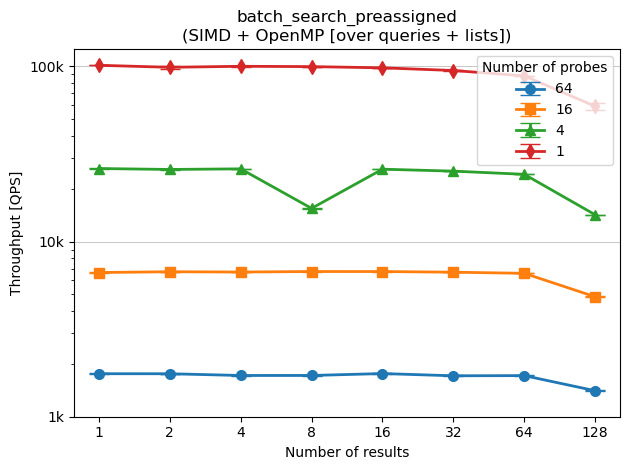

In [86]:
plot(df=search_simd_omp_pmode2_varying_nresults_df, y_col='queries_per_s', yerr_col='queries_per_s_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists])', ylabel='Throughput [QPS]', yformatter=to_k_formatter, mode='n_results', yaxis_log=True, yaxis_bottom=1e3)

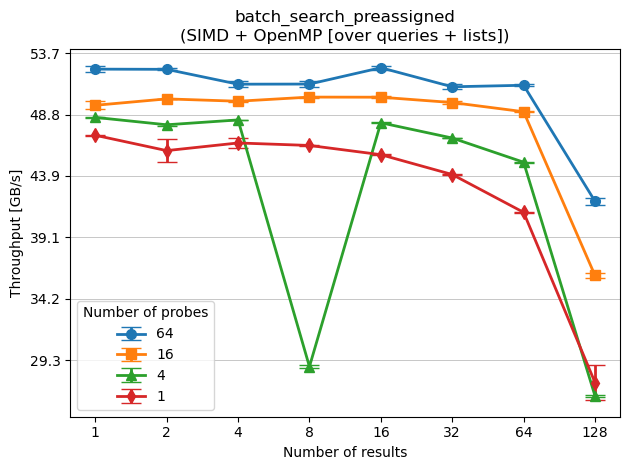

In [87]:
plot(df=search_simd_omp_pmode2_varying_nresults_df, y_col='mb_per_s', yerr_col='mb_per_s_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists])', ylabel='Throughput [GB/s]', mode='n_results', yaxis_log=False, yformatter=mb_to_gb_formatter, filename='omp2-search-throughput-n-results')

**Latency**

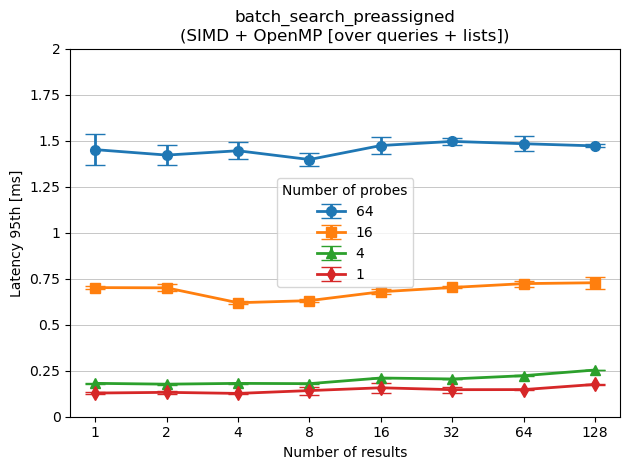

In [88]:
plot(df=search_simd_omp_pmode2_varying_nresults_latency_df, y_col='latency_95th', yerr_col='latency_95th_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists])', ylabel='Latency 95th [ms]', mode='n_results', yformatter=s_to_ms_formatter, yaxis_log=False, yaxis_bottom=0, yaxis_top=2e-3, filename='omp2-search-latency-95-n-results')

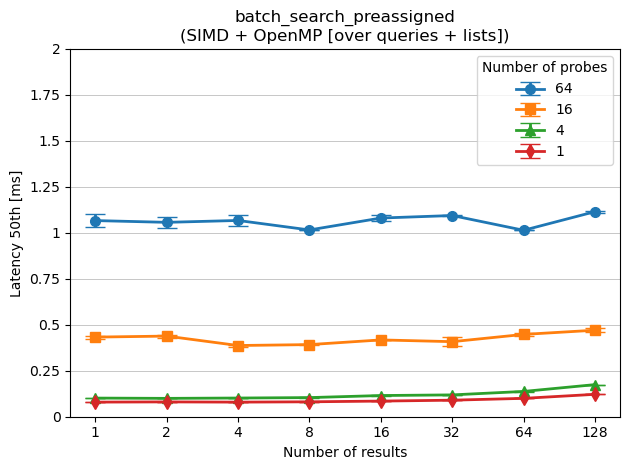

In [89]:
plot(df=search_simd_omp_pmode2_varying_nresults_latency_df, y_col='latency_50th', yerr_col='latency_50th_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists])', ylabel='Latency 50th [ms]', mode='n_results', yformatter=s_to_ms_formatter, yaxis_log=False, yaxis_bottom=0, yaxis_top=2e-3, filename='omp2-search-latency-50-n-results')

**Recall**


In [90]:
search_recall_simd_omp_pmode2_df = results_to_df(merge_results('recall', lambda f: True, 'recall'), mode="search_preassigned")
search_recall_simd_omp_pmode2_df = search_recall_simd_omp_pmode2_df.sort_values(by=['n_lists', 'n_probes'])
search_recall_simd_omp_pmode2_df

O OMP_SCHEDULE  max_n_threads INSERTION_STRATEGY  MAX_BUFFER_SIZE  \
0   3      dynamic             32            dynamic              100   
1   3      dynamic             32            dynamic              100   
2   3      dynamic             32            dynamic              100   
3   3      dynamic             32            dynamic              100   
4   3      dynamic             32            dynamic              100   
5   3      dynamic             32            dynamic              100   
6   3      dynamic             32            dynamic              100   
7   3      dynamic             32            dynamic              100   
8   3      dynamic             32            dynamic              100   
9   3      dynamic             32            dynamic              100   
10  3      dynamic             32            dynamic              100   
11  3      dynamic             32            dynamic              100   
12  3      dynamic             32            dynamic              100   
13  3      dynamic             32            dynamic              100   
14  3      dynamic             32            dynamic              100   
15  3      dynamic             32            dynamic              100   
16  3      dynamic             32            dynamic              100   
17  3      dynamic             32            dynamic              100   
18  3      dynamic             32            dynamic              100   
19  3      dynamic             32            dynamic              100   
20  3      dynamic             32            dynamic              100   
21  3      dynamic             32            dynamic              100   
22  3      dynamic             32            dynamic              100   
23  3      dynamic             32            dynamic              100   
24  3      dynamic             32            dynamic              100   
25  3      dynamic             32            dynamic              100   
26  3      dynamic             32            dynamic              100   
27  3      dynamic             32            dynamic              100   
28  3      dynamic             32            dynamic              100   
29  3      dynamic             32            dynamic              100   
30  3      dynamic             32            dynamic              100   
31  3      dynamic             32            dynamic              100   
32  3      dynamic             32            dynamic              100   
33  3      dynamic             32            dynamic              100   
34  3      dynamic             32            dynamic              100   
35  3      dynamic             32            dynamic              100   
36  3      dynamic             32            dynamic              100   
37  3      dynamic             32            dynamic              100   
38  3      dynamic             32            dynamic              100   
39  3      dynamic             32            dynamic              100   

    n_lists  n_probes  n_results  recall@1  
0       256         1         10    0.5279  
1       256         2         10    0.7097  
2       256         4         10    0.8587  
3       256         8         10    0.9431  
4       256        16         10    0.9858  
5       256        32         10    0.9970  
6       256        64         10    0.9999  
7       256       128         10    1.0000  
8       512         1         10    0.4822  
9       512         2         10    0.6528  
10      512         4         10    0.8037  
11      512         8         10    0.9066  
12      512        16         10    0.9711  
13      512        32         10    0.9942  
14      512        64         10    0.9989  
15      512       128         10    0.9999  
16     1024         1         10    0.4377  
17     1024         2         10    0.6024  
18     1024         4         10    0.7573  
19     1024         8         10    0.8720  
20     1024        16         10    0.9476  
21     1024        3

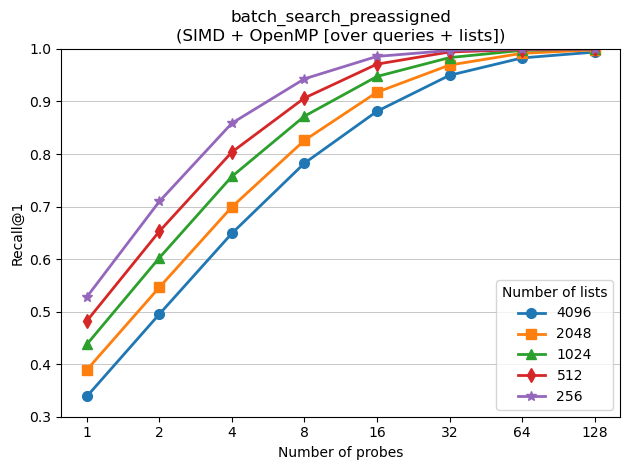

In [91]:
plot(df=search_recall_simd_omp_pmode2_df, y_col='recall@1', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists])', ylabel='Recall@1', mode='recall', yaxis_log=False, yaxis_bottom=0.3, yaxis_top=1, filename='omp2-search-recall-1')